In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.dataclasses import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_sample_from_json, get_features_from_folder
from copy import deepcopy
import pandas as pd
from matplotlib.gridspec import GridSpec

In [2]:
import warnings
warnings.filterwarnings("ignore") # disable due to kmeans initialization

In [3]:
plt.style.use('default')

In [4]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

# Importing data

In [5]:
band_limits = [
    0,
    5,
    20,
    32,
    40,
    55,
    75,
    100,
    120,
    128
]

In [6]:
band_pairs = [(band_limits[i], band_limits[i+1]) for i in range(len(band_limits)-1)]

Dataset 1

In [7]:
dataset_1 = get_features_from_folder(
    path=PATH_TO_DATASET_1,
    band_pairs=band_pairs,
    min_valid_date=datetime(2022, 11, 18, 10, 19)
)

100%|██████████| 2865/2865 [01:58<00:00, 24.24it/s] 


In [8]:
dataset_2 = get_features_from_folder(
    path=PATH_TO_DATASET_2,
    band_pairs=band_pairs,
    min_valid_date=datetime(2023, 1, 7, 10, 00)
)

100%|██████████| 4420/4420 [02:33<00:00, 28.73it/s]


# Visualization

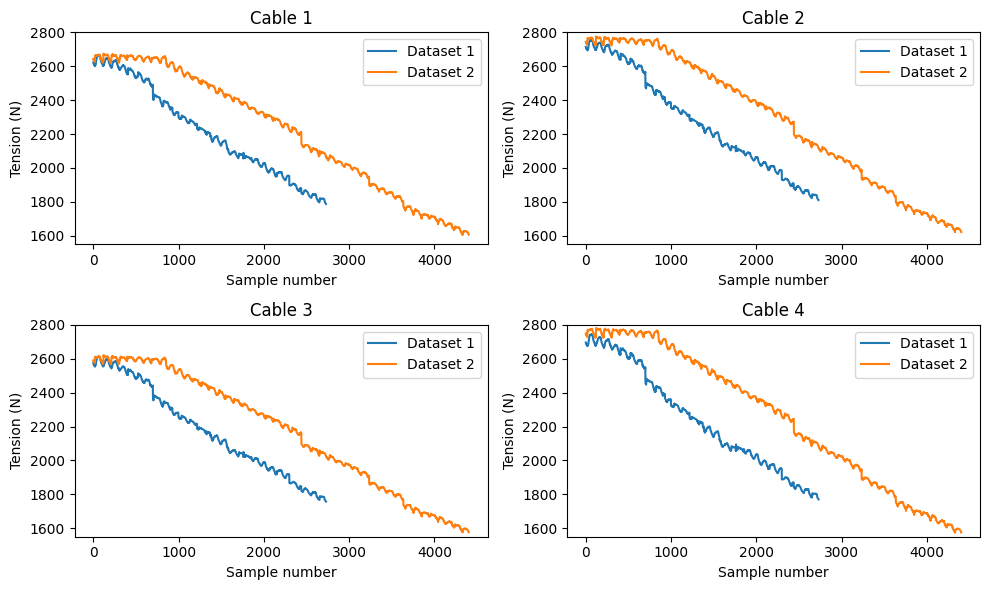

In [9]:
plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.plot(dataset_1[f"c{cable}"].tension.to_numpy())
    plt.plot(dataset_2[f"c{cable}"].tension.to_numpy())
    plt.legend(["Dataset 1", "Dataset 2"])
    plt.ylim([1550, 2800])
    plt.xlabel("Sample number")
    plt.ylabel("Tension (N)")
plt.tight_layout()

## Features vs time

In [10]:
for cable in range(4):
    dataset_1[f"c{cable}"]["time_from_start"] = dataset_1[f"c{cable}"].index - dataset_1["c0"].index.min()
    dataset_2[f"c{cable}"]["time_from_start"] = dataset_2[f"c{cable}"].index - dataset_2[f"c{cable}"].index.min()
    dataset_1[f"c{cable}"]["hours_from_start"] = (dataset_1[f"c{cable}"]["time_from_start"] * 1e-9) / 3600
    dataset_2[f"c{cable}"]["hours_from_start"] = (dataset_2[f"c{cable}"]["time_from_start"] * 1e-9) / 3600

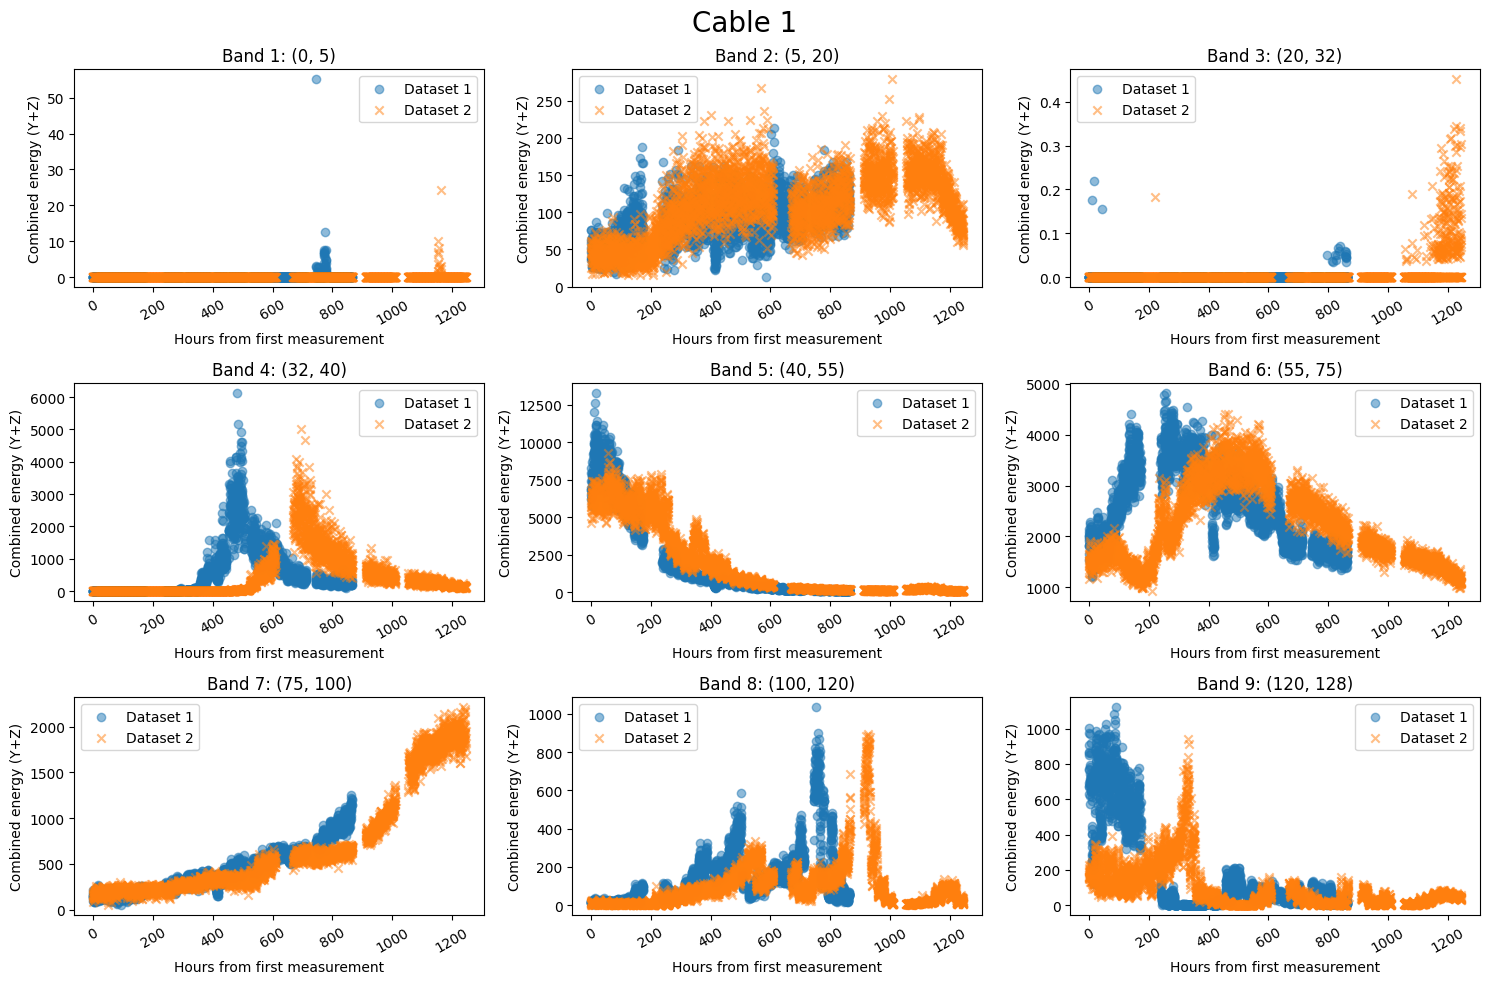

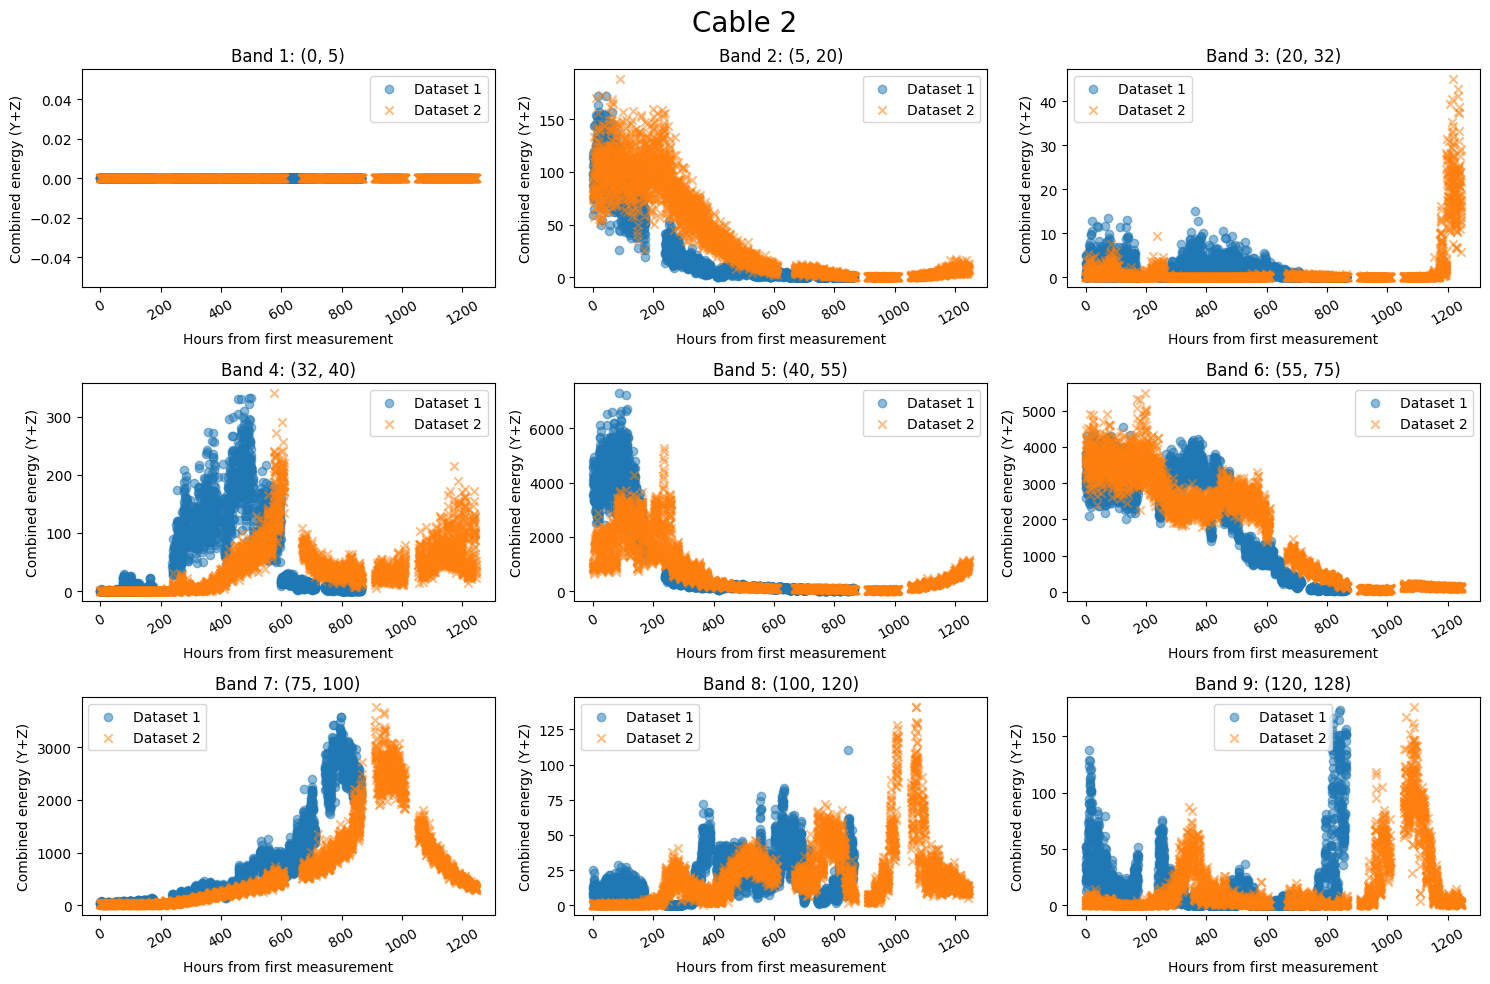

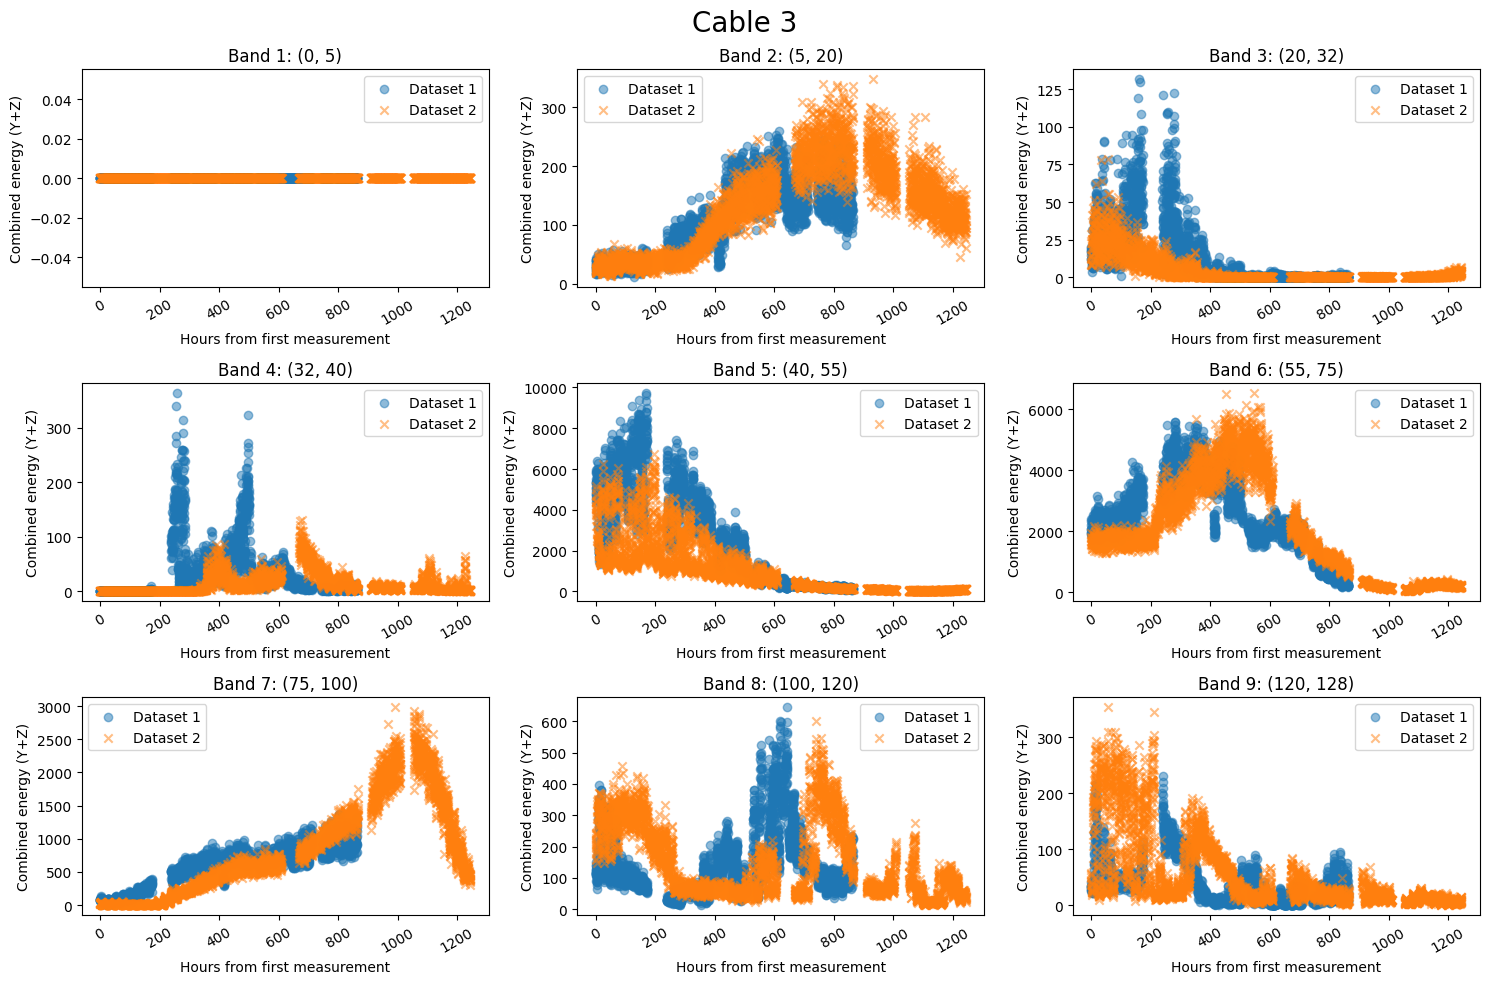

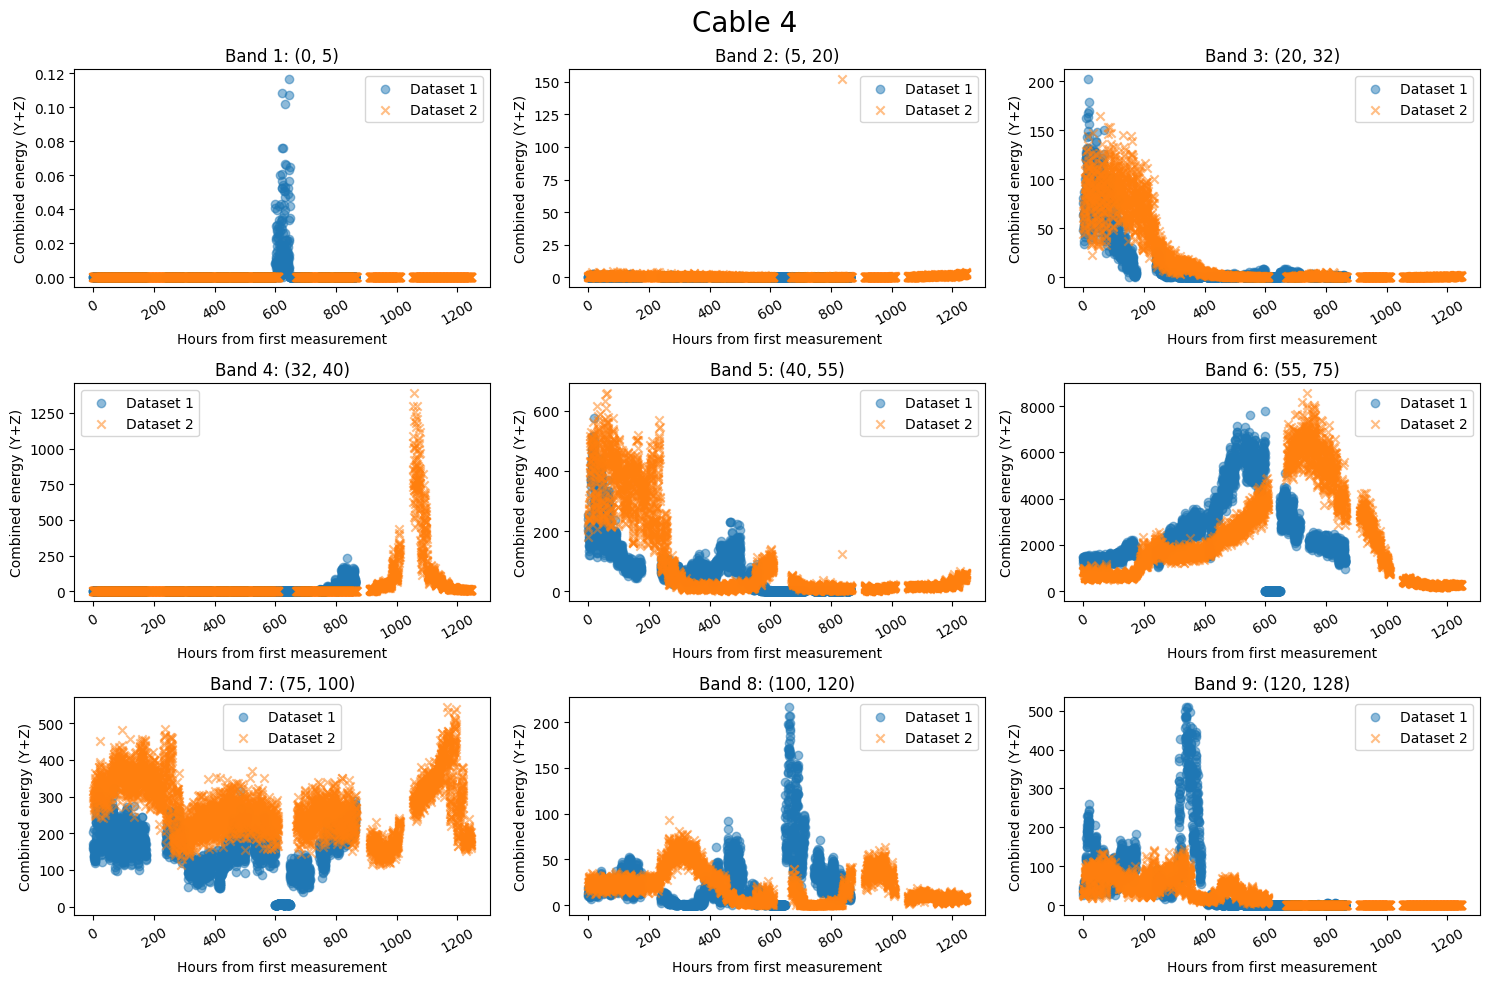

In [11]:
# max_cable_1 = np.max([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
# max_cable_2 = np.max([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])

# min_cable_1 = np.min([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
# min_cable_2 = np.min([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])

# global_max = np.max((max_cable_1, max_cable_2))
# global_min = np.min((min_cable_1, min_cable_2))

for cable in range(4):
    plt.figure(figsize=(15,10))
    plt.suptitle(f"Cable {cable+1}", fontsize=20)
    for band in range(len(band_pairs)): 
        plt.subplot(3,3,band+1)
        plt.title(f"Band {band+1}: {band_pairs[band]}")
        plt.scatter(dataset_1[f"c{cable}"].hours_from_start, dataset_1[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="o")
        plt.scatter(dataset_2[f"c{cable}"].hours_from_start, dataset_2[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="x")
        # plt.scatter(tensions_dataset_2[f"{cable}"], band_matrices_dataset_2[f"{cable}"][:,band], alpha=0.5)
        # plt.ylim([global_min, global_max])
        plt.xlabel("Hours from first measurement")
        plt.ylabel("Combined energy (Y+Z)")
        plt.xticks(rotation=30)
        plt.legend(["Dataset 1", "Dataset 2"])
    plt.tight_layout()

In [12]:
gb_dataset_1 = {f"c{cable}": dataset_1[f"c{cable}"].groupby([dataset_1[f"c{cable}"].index.hour, dataset_1[f"c{cable}"].index.day, dataset_1[f"c{cable}"].index.month]).mean() for cable in range(4)}
gb_dataset_2 = {f"c{cable}": dataset_2[f"c{cable}"].groupby([dataset_2[f"c{cable}"].index.hour, dataset_2[f"c{cable}"].index.day, dataset_2[f"c{cable}"].index.month]).mean() for cable in range(4)}

In [13]:
for k in range(4):
    gb_dataset_1[f"c{k}"]["sampled_at"] = [datetime(year=2022, hour=x[0], day=x[1], month=x[2]) for x in gb_dataset_1[f"c{k}"].index.to_list()]
    gb_dataset_2[f"c{k}"]["sampled_at"] = [datetime(year=2023, hour=x[0], day=x[1], month=x[2]) for x in gb_dataset_2[f"c{k}"].index.to_list()]

    gb_dataset_1[f"c{k}"].reset_index(drop=True, inplace=True)
    gb_dataset_2[f"c{k}"].reset_index(drop=True, inplace=True)

for k in range(4):
    gb_dataset_1[f"c{k}"] = gb_dataset_1[f"c{k}"].sort_values("sampled_at")
    gb_dataset_2[f"c{k}"] = gb_dataset_2[f"c{k}"].sort_values("sampled_at")

In [14]:
len(dataset_1["c0"]), len(gb_dataset_1["c0"])

(2730, 692)

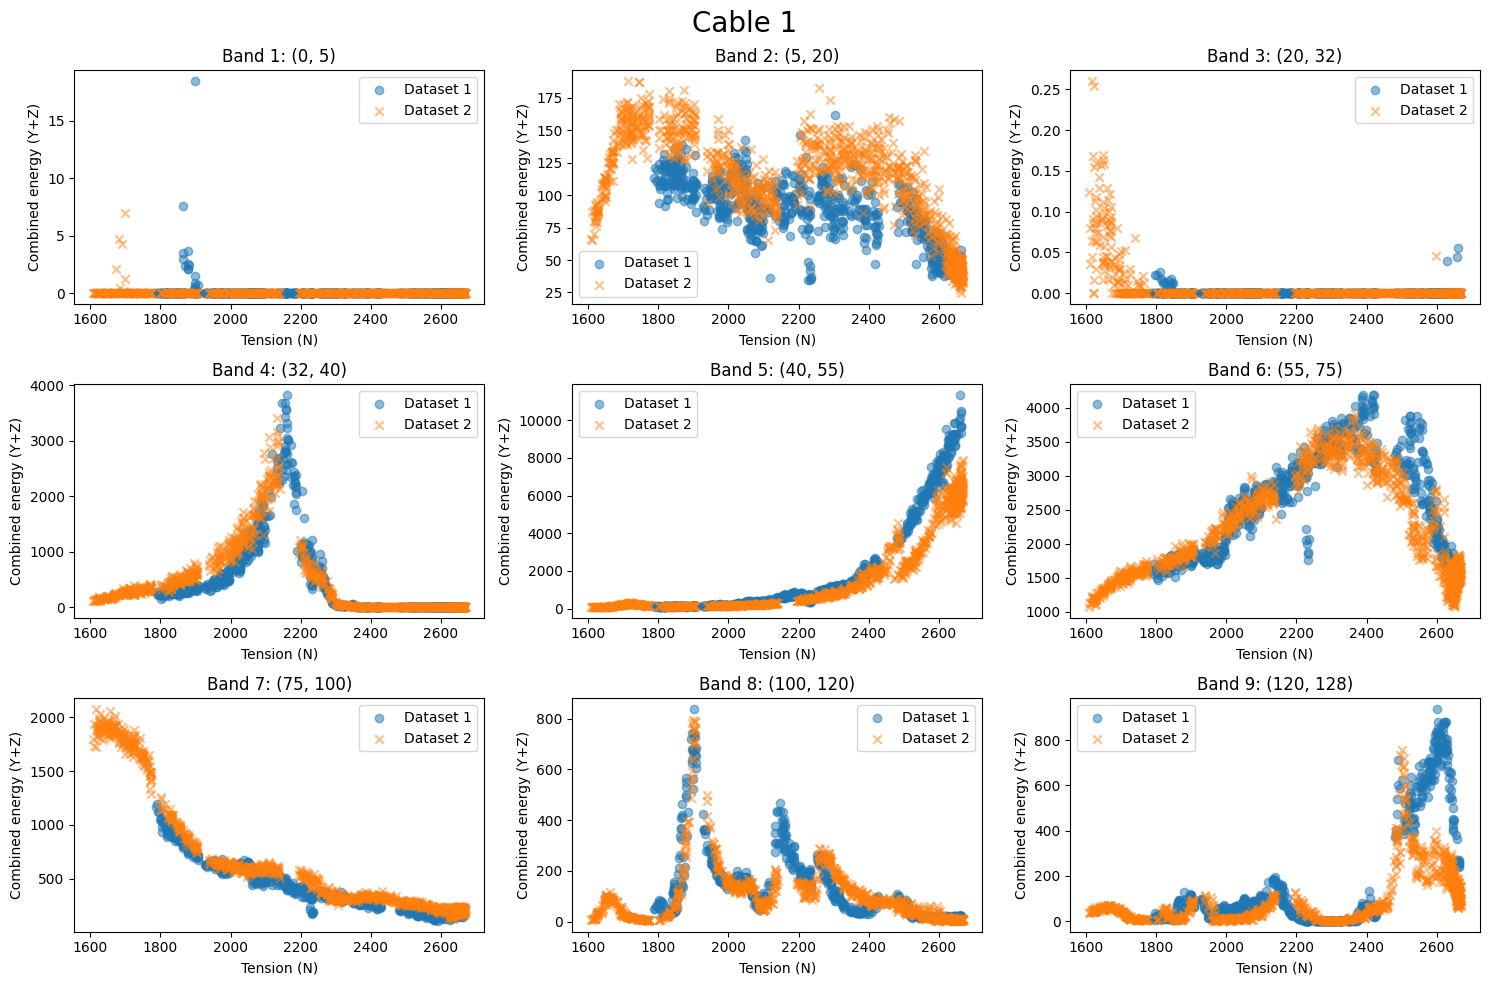

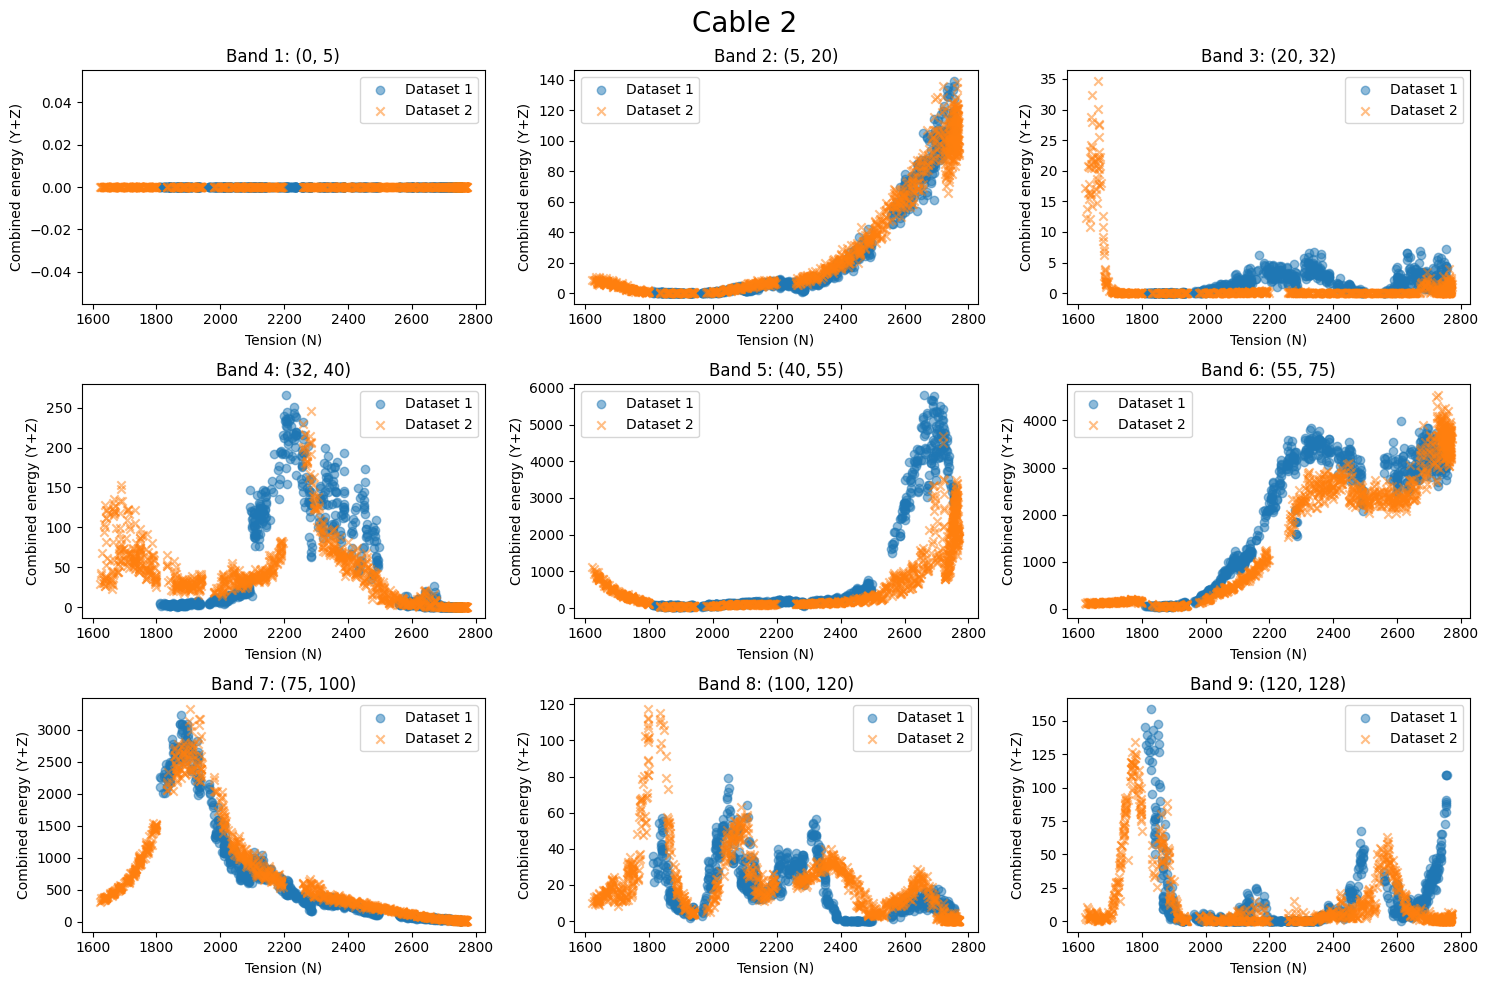

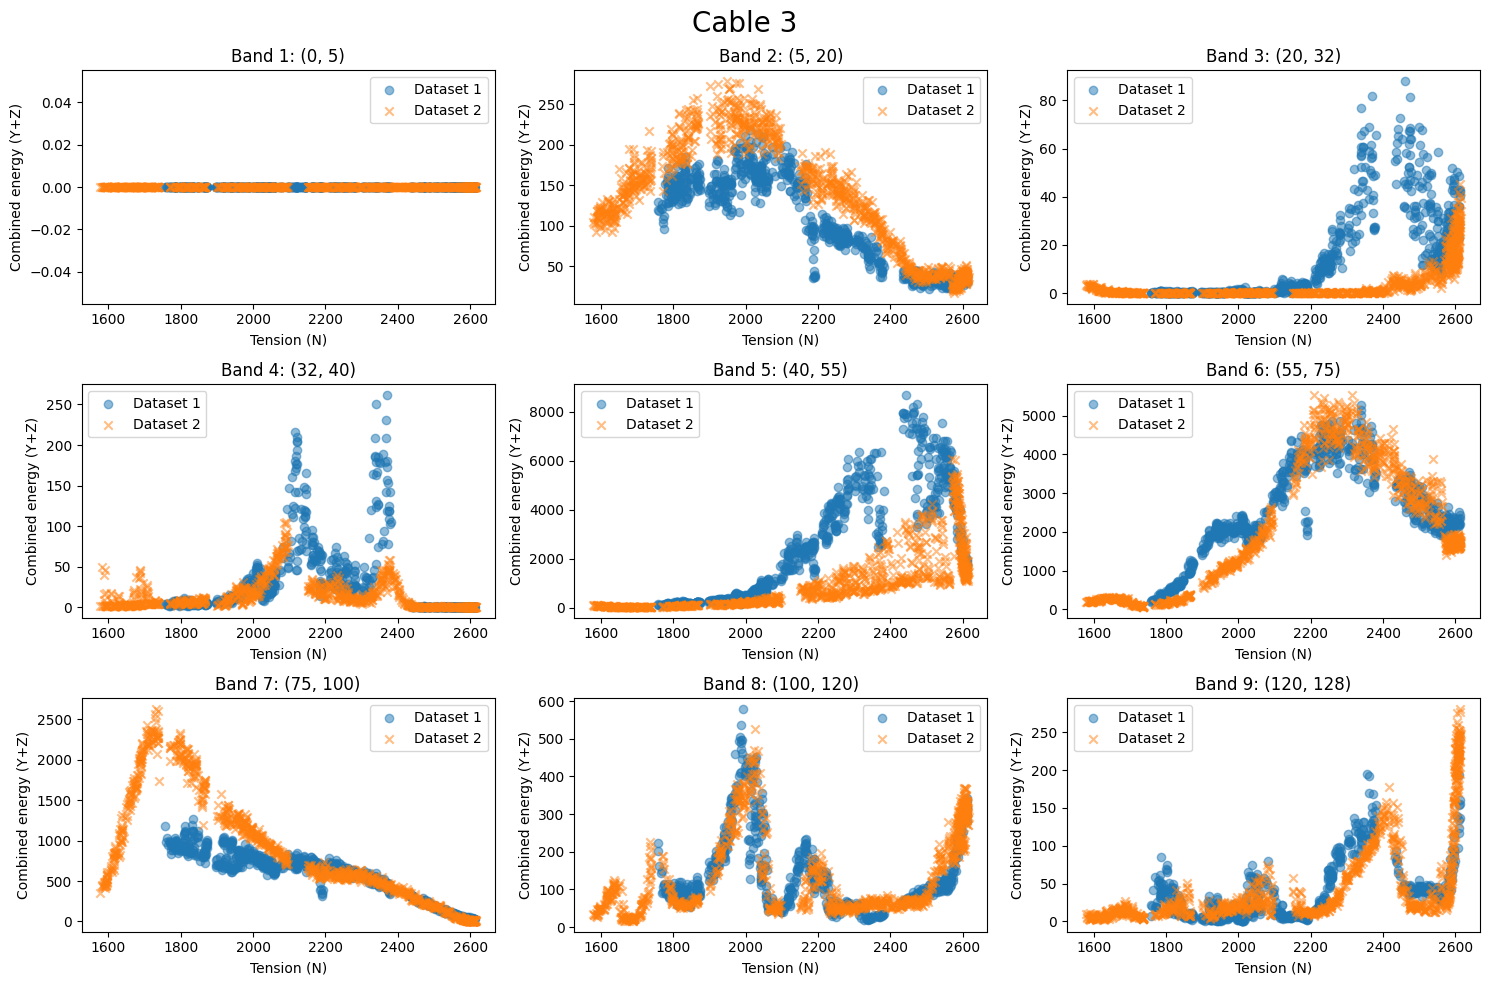

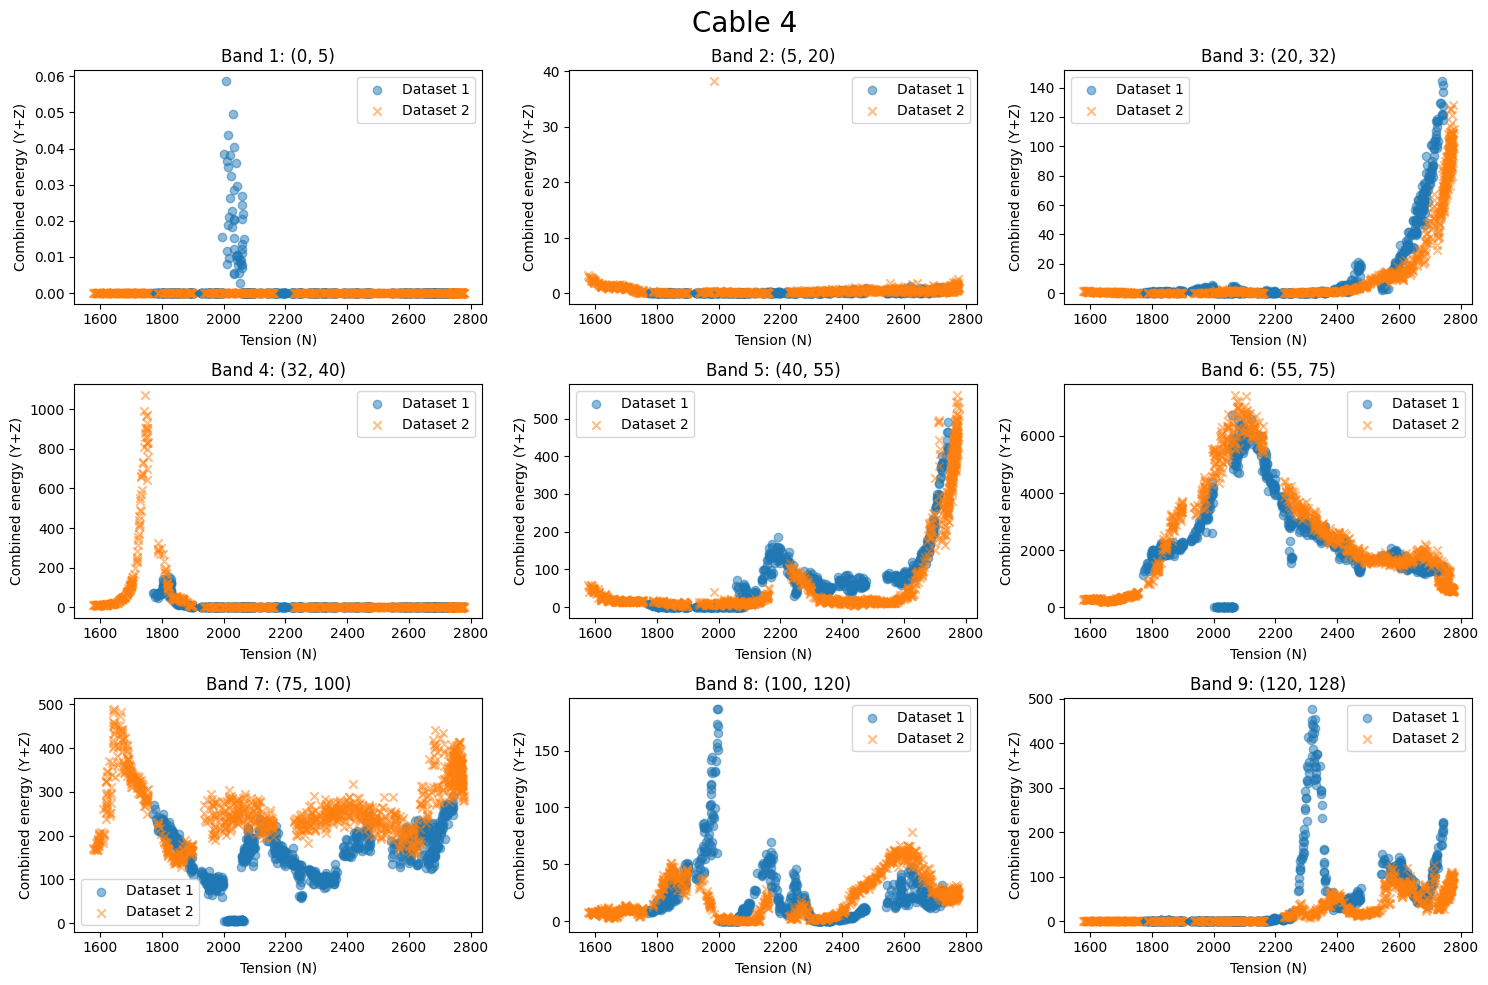

In [15]:
for cable in range(4):
    plt.figure(figsize=(15,10))
    plt.suptitle(f"Cable {cable+1}", fontsize=20)
    for band in range(len(band_pairs)): 
        plt.subplot(3,3,band+1)
        plt.title(f"Band {band+1}: {band_pairs[band]}")
        plt.scatter(gb_dataset_1[f"c{cable}"].tension, gb_dataset_1[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="o")
        plt.scatter(gb_dataset_2[f"c{cable}"].tension, gb_dataset_2[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="x")
        # plt.scatter(tensions_dataset_2[f"{cable}"], band_matrices_dataset_2[f"{cable}"][:,band], alpha=0.5)
        # plt.ylim([global_min, global_max])
        plt.xlabel("Tension (N)")
        plt.ylabel("Combined energy (Y+Z)")
        plt.legend(["Dataset 1", "Dataset 2"])
    plt.tight_layout()

## Features vs tension

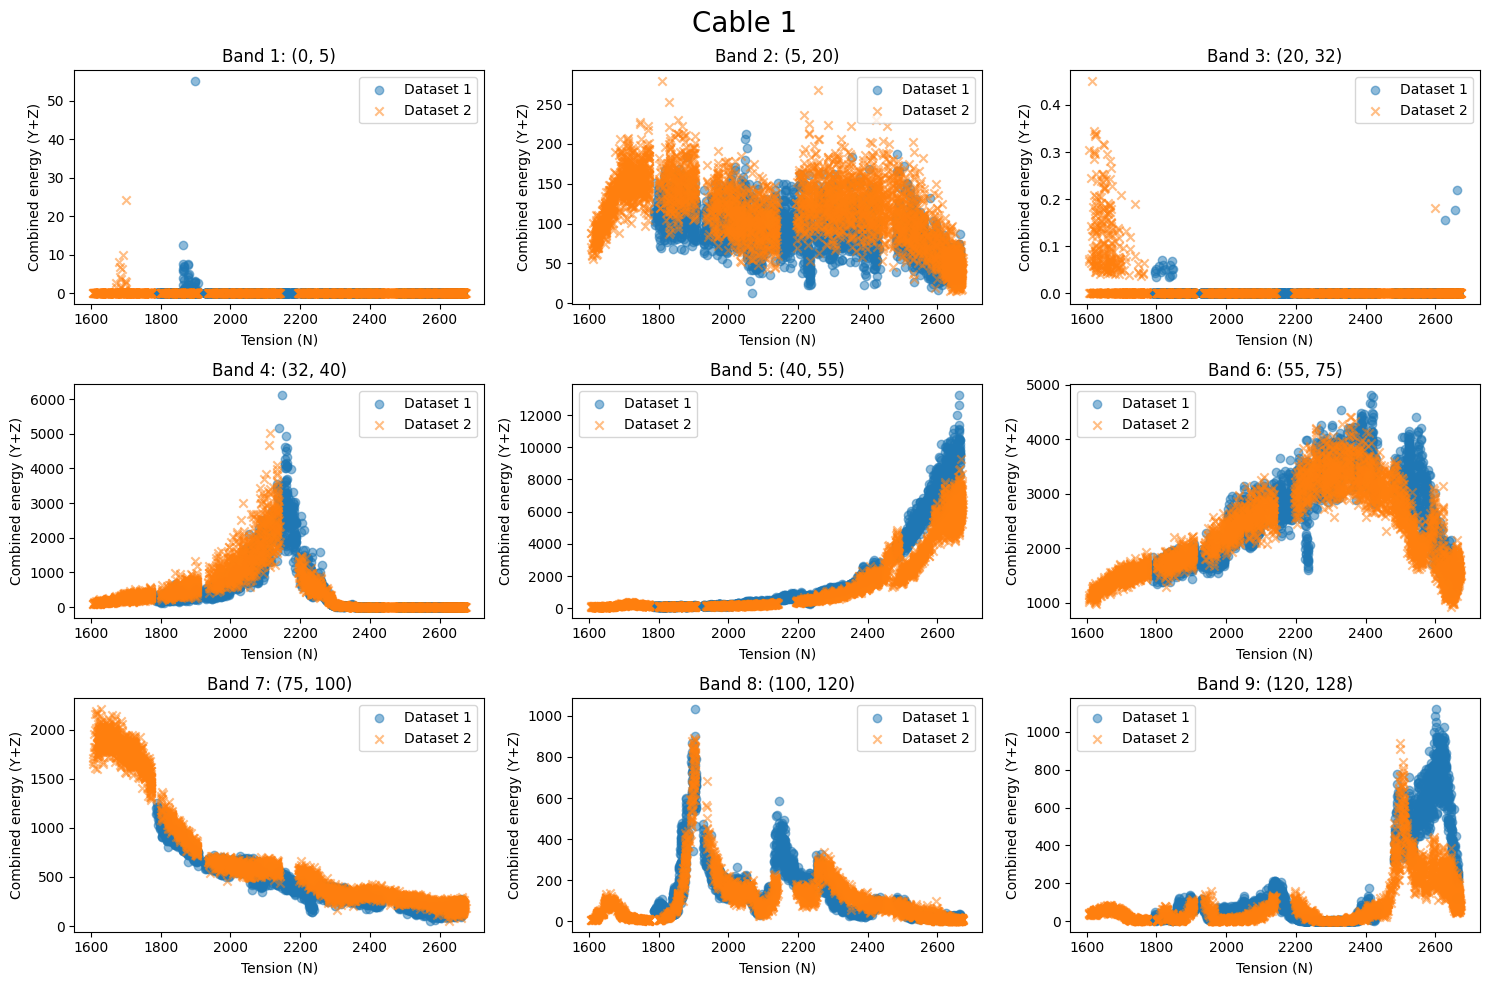

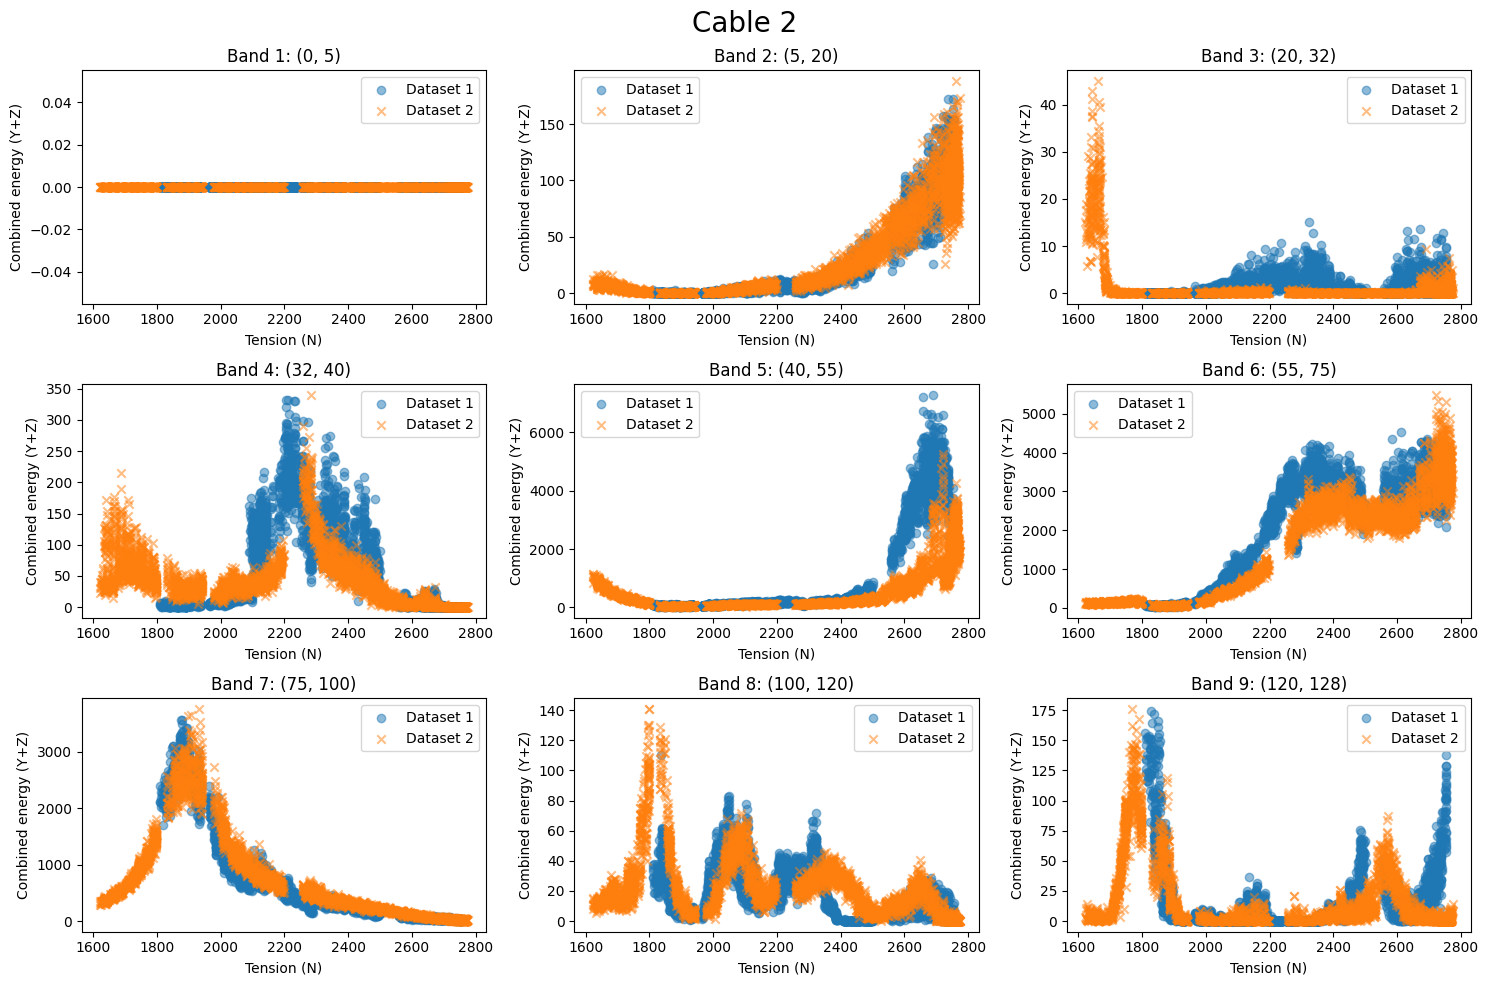

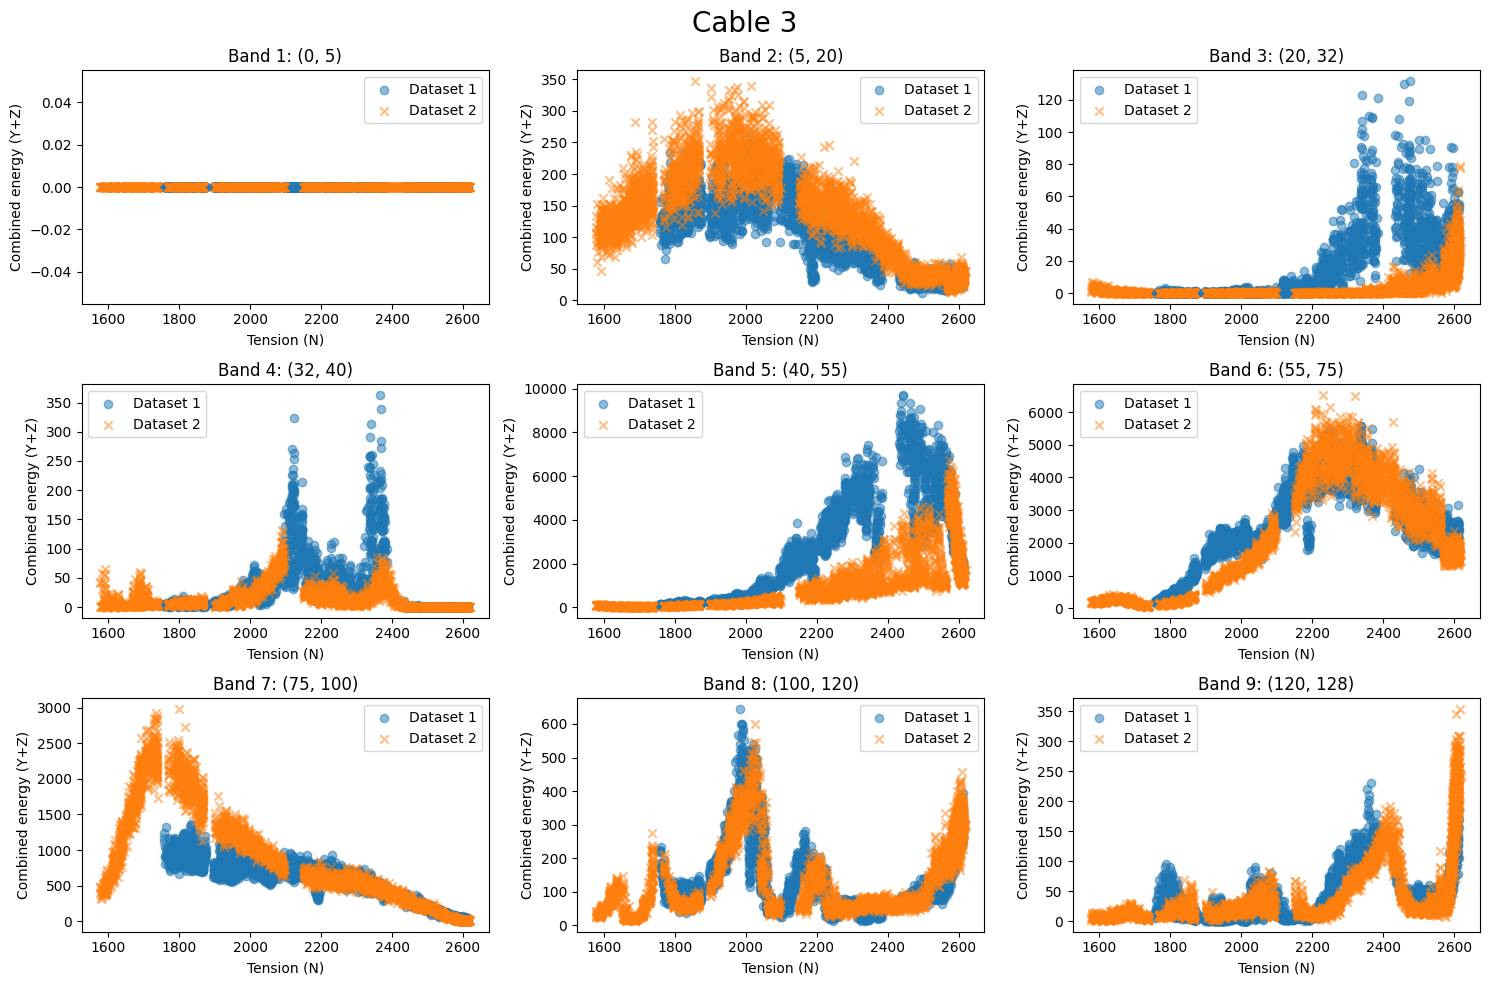

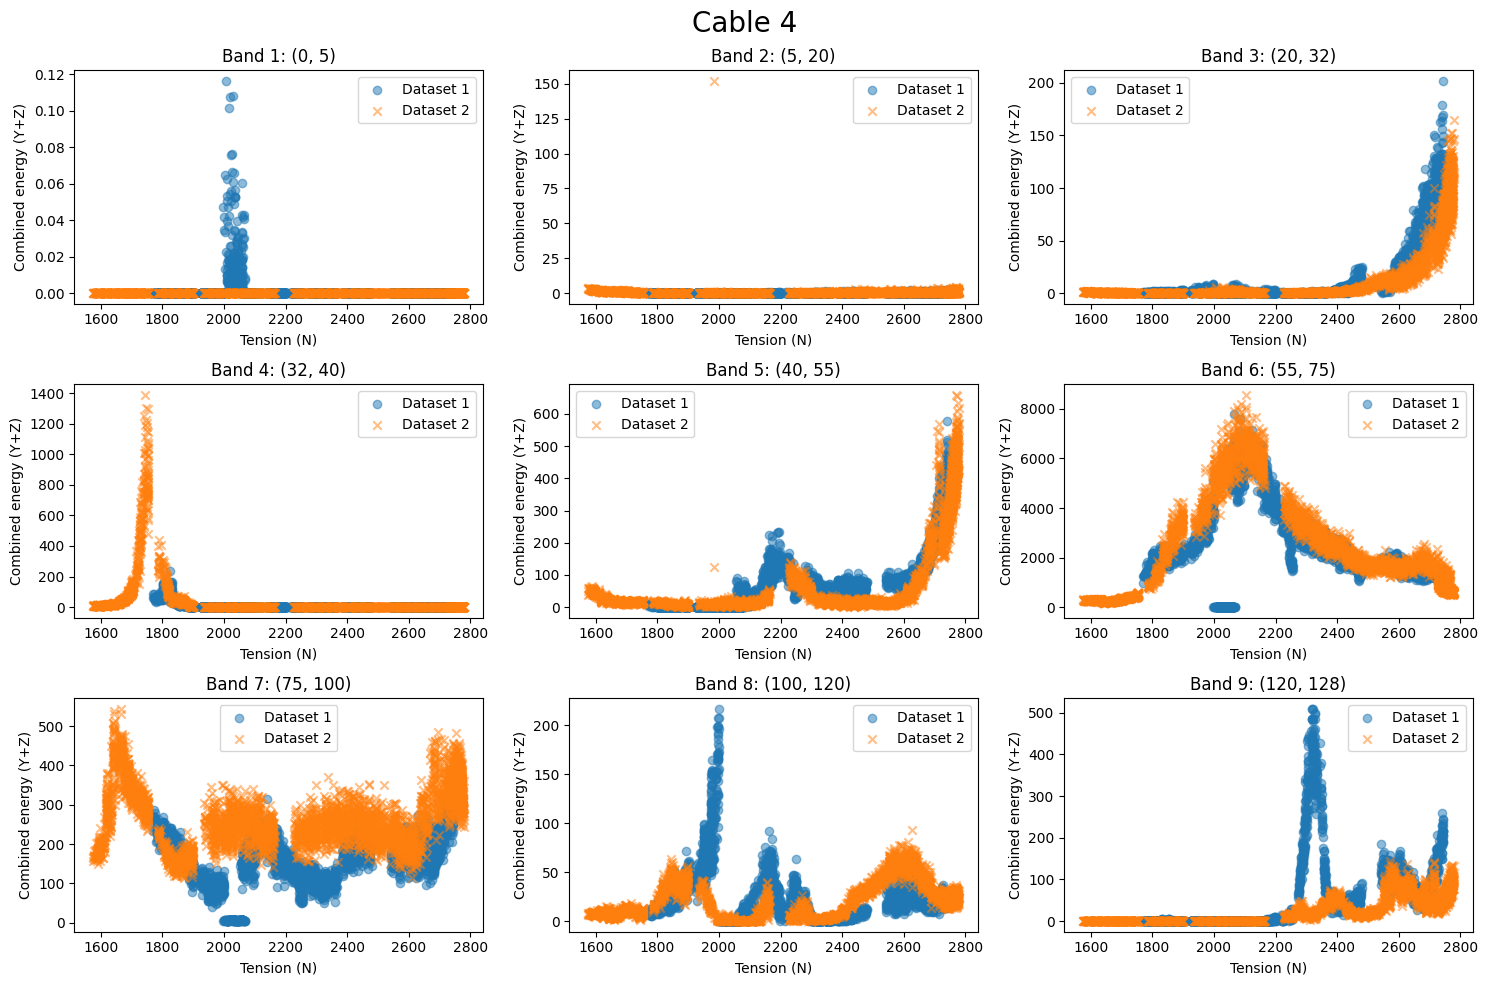

In [16]:
# max_cable_1 = np.max([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
# max_cable_2 = np.max([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])

# min_cable_1 = np.min([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
# min_cable_2 = np.min([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])

# global_max = np.max((max_cable_1, max_cable_2))
# global_min = np.min((min_cable_1, min_cable_2))

for cable in range(4):
    plt.figure(figsize=(15,10))
    plt.suptitle(f"Cable {cable+1}", fontsize=20)
    for band in range(len(band_pairs)): 
        plt.subplot(3,3,band+1)
        plt.title(f"Band {band+1}: {band_pairs[band]}")
        plt.scatter(dataset_1[f"c{cable}"].tension, dataset_1[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="o")
        plt.scatter(dataset_2[f"c{cable}"].tension, dataset_2[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="x")
        # plt.scatter(tensions_dataset_2[f"{cable}"], band_matrices_dataset_2[f"{cable}"][:,band], alpha=0.5)
        # plt.ylim([global_min, global_max])
        plt.xlabel("Tension (N)")
        plt.ylabel("Combined energy (Y+Z)")
        plt.legend(["Dataset 1", "Dataset 2"])
    plt.tight_layout()

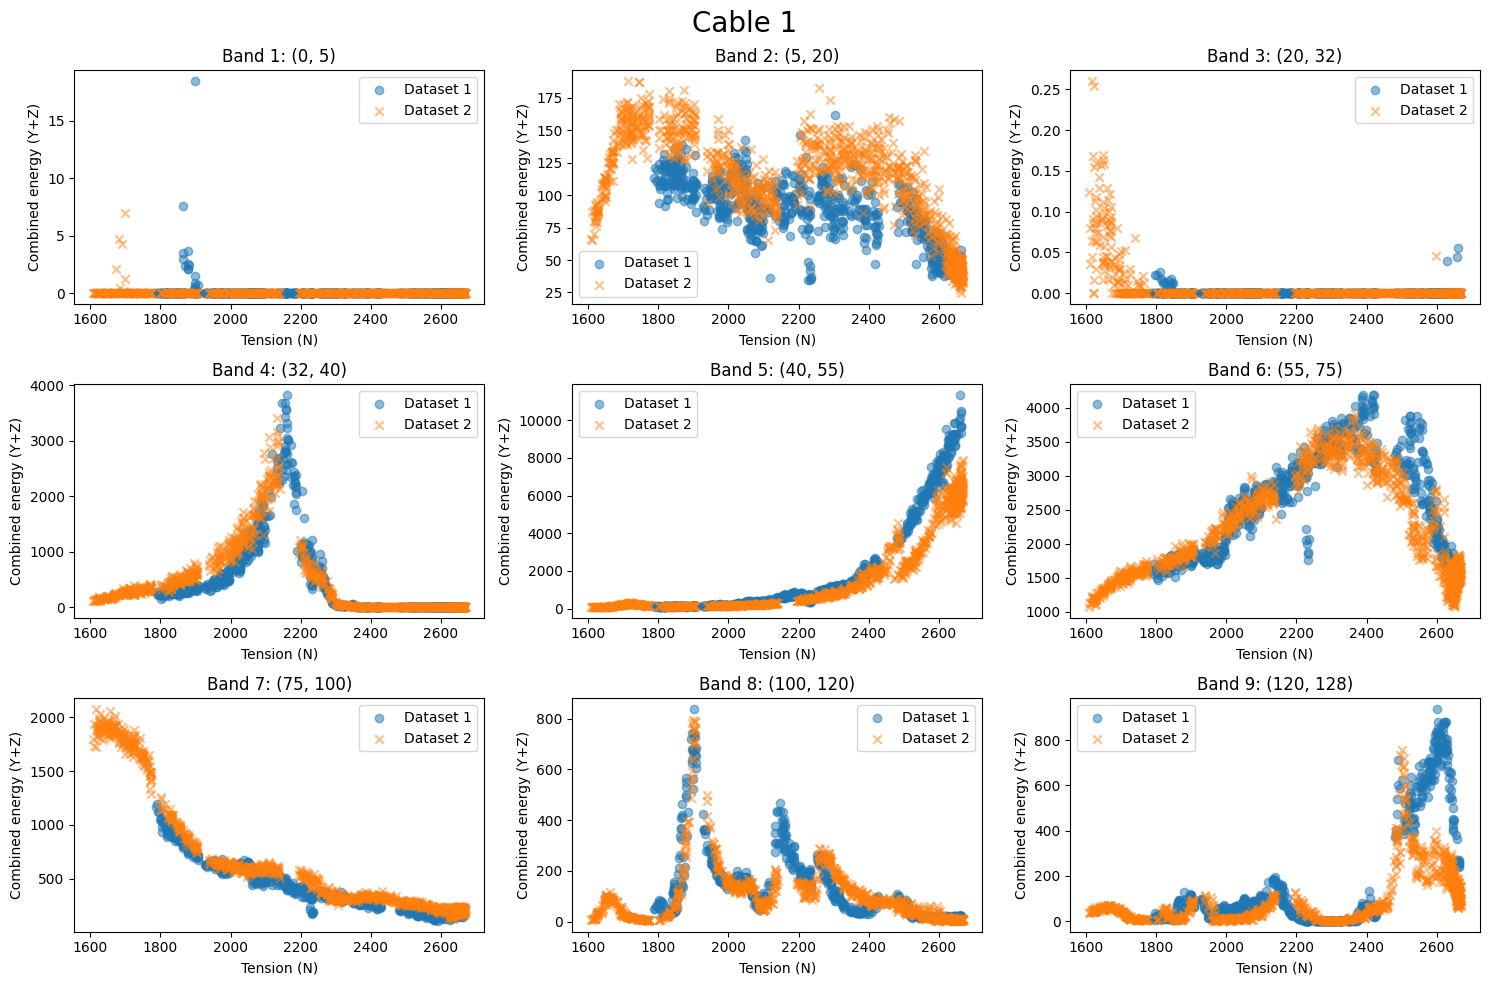

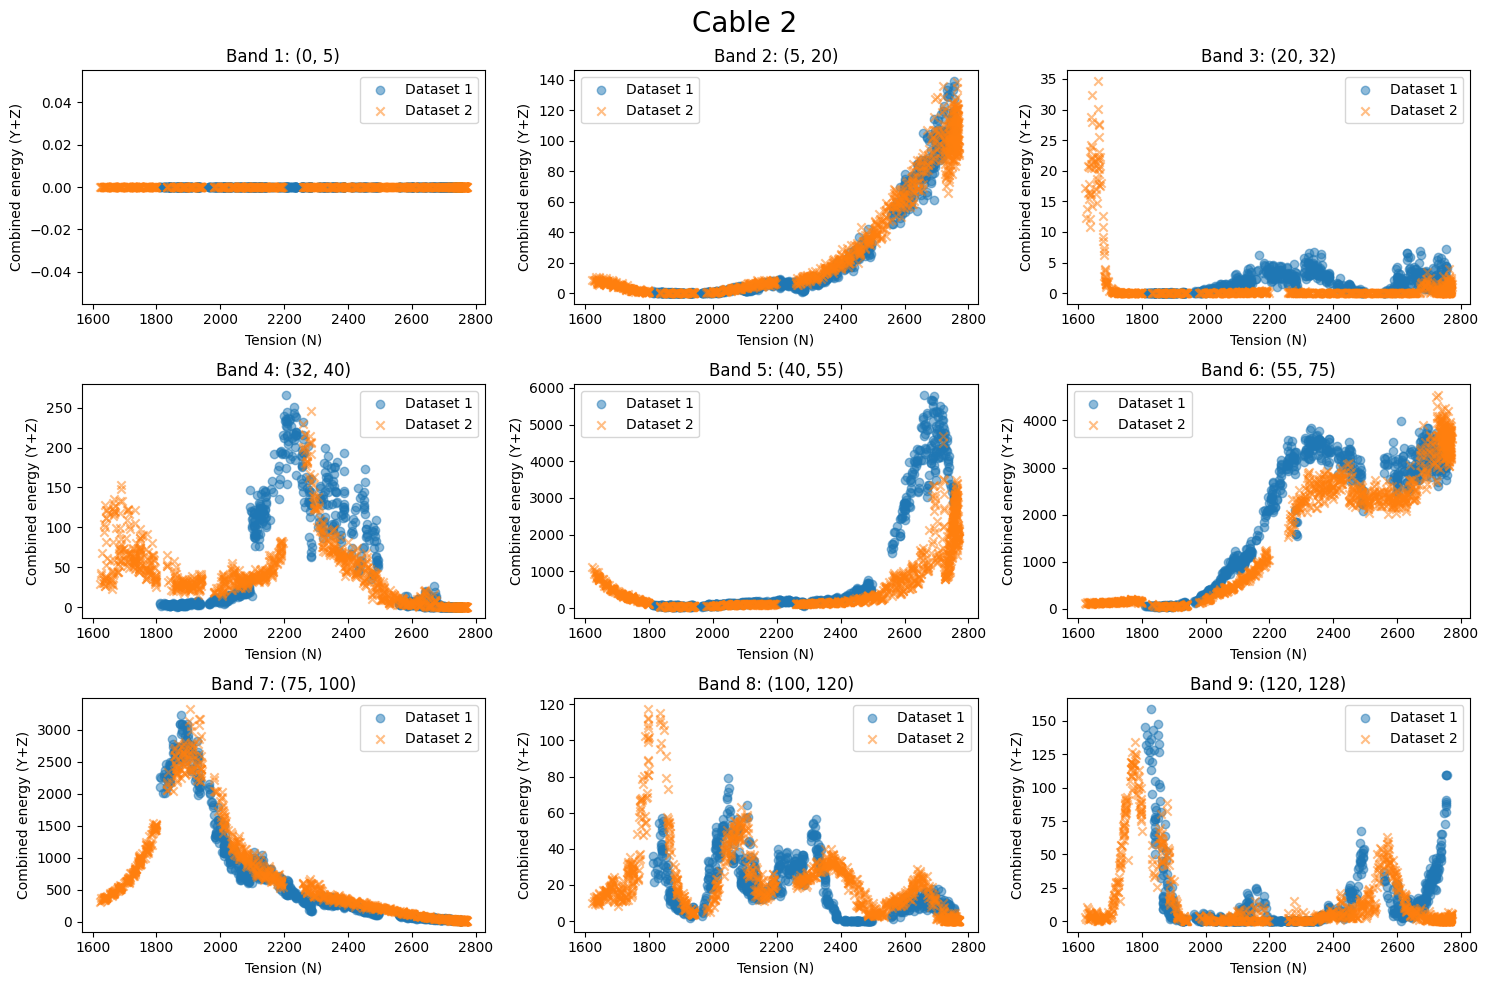

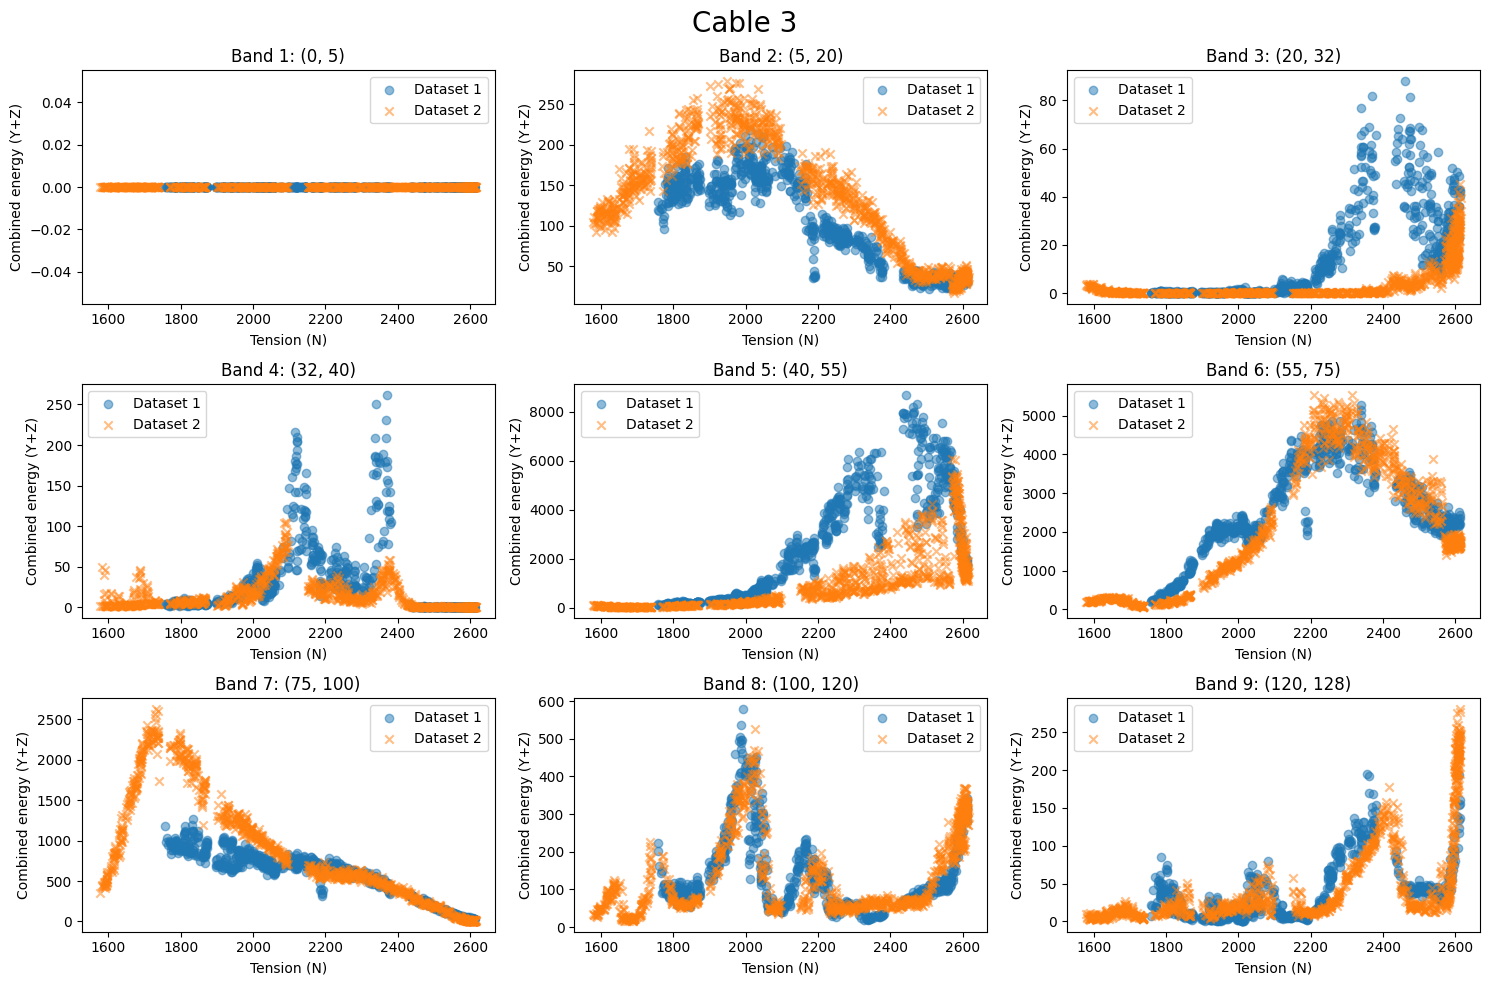

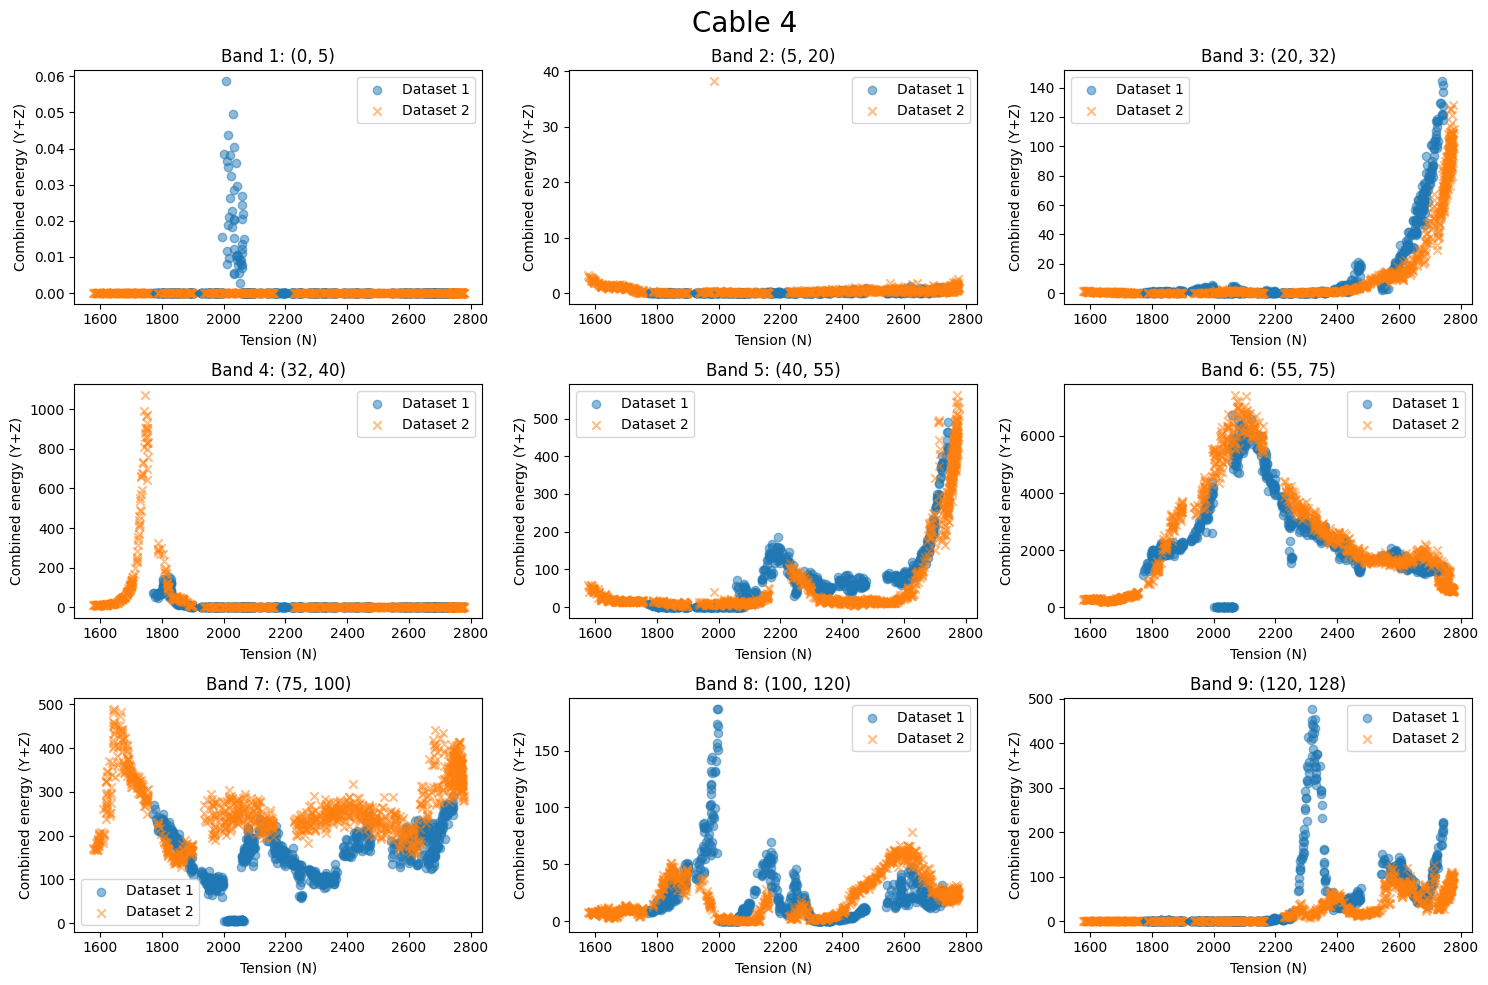

In [17]:
# max_cable_1 = np.max([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
# max_cable_2 = np.max([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])

# min_cable_1 = np.min([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
# min_cable_2 = np.min([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])

# global_max = np.max((max_cable_1, max_cable_2))
# global_min = np.min((min_cable_1, min_cable_2))

for cable in range(4):
    plt.figure(figsize=(15,10))
    plt.suptitle(f"Cable {cable+1}", fontsize=20)
    for band in range(len(band_pairs)): 
        plt.subplot(3,3,band+1)
        plt.title(f"Band {band+1}: {band_pairs[band]}")
        plt.scatter(gb_dataset_1[f"c{cable}"].tension, gb_dataset_1[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="o")
        plt.scatter(gb_dataset_2[f"c{cable}"].tension, gb_dataset_2[f"c{cable}"].to_numpy()[:,band], alpha=0.5, marker="x")
        # plt.scatter(tensions_dataset_2[f"{cable}"], band_matrices_dataset_2[f"{cable}"][:,band], alpha=0.5)
        # plt.ylim([global_min, global_max])
        plt.xlabel("Tension (N)")
        plt.ylabel("Combined energy (Y+Z)")
        plt.legend(["Dataset 1", "Dataset 2"])
    plt.tight_layout()

# Training one model per cable

Training: dataset 2

Testing: dataset 1

In [18]:
from hmmlearn.hmm import GMMHMM

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [20]:
from lib.hmm_utils import (
    train_hmm,
    initialize_left_right,
    initialize_left_right_common,
    initialize_neighbor,
    make_hmm,
    make_categorical_hmm
)

### No restriction

In [21]:
selected_bands = {
    "c0": ["band_5", "band_6", "band_7"],
    "c1": ["band_2", "band_6", "band_7"],
    "c2": ["band_6", "band_8"],
    "c3": ["band_5", "band_6"],
}

In [22]:
from hmmlearn.hmm import CategoricalHMM
from models.kmeans_quantizer import KMeansQuantizer

In [137]:
def get_state_order(labels: list):
    time = np.arange(len(labels))
    traj = pd.DataFrame({"time": time, "label": labels})
    grouped = traj.groupby("label").mean()
    original_labels = grouped.index.to_numpy()
    idx = original_labels[grouped.time.to_numpy().argsort()]
    mapping = {k: v for k,v in zip(idx, original_labels)} # old_state: new_state
    return mapping

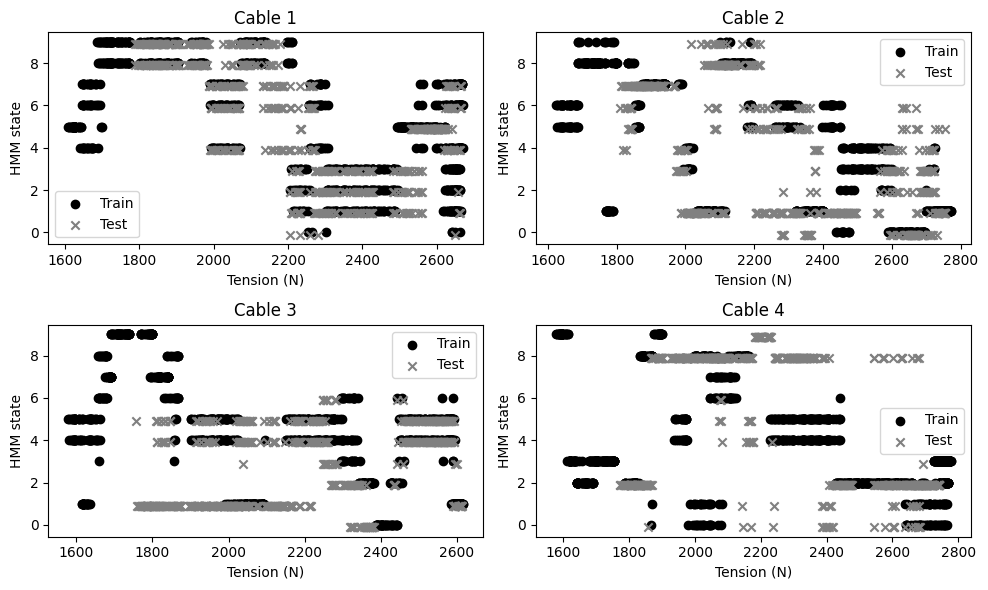

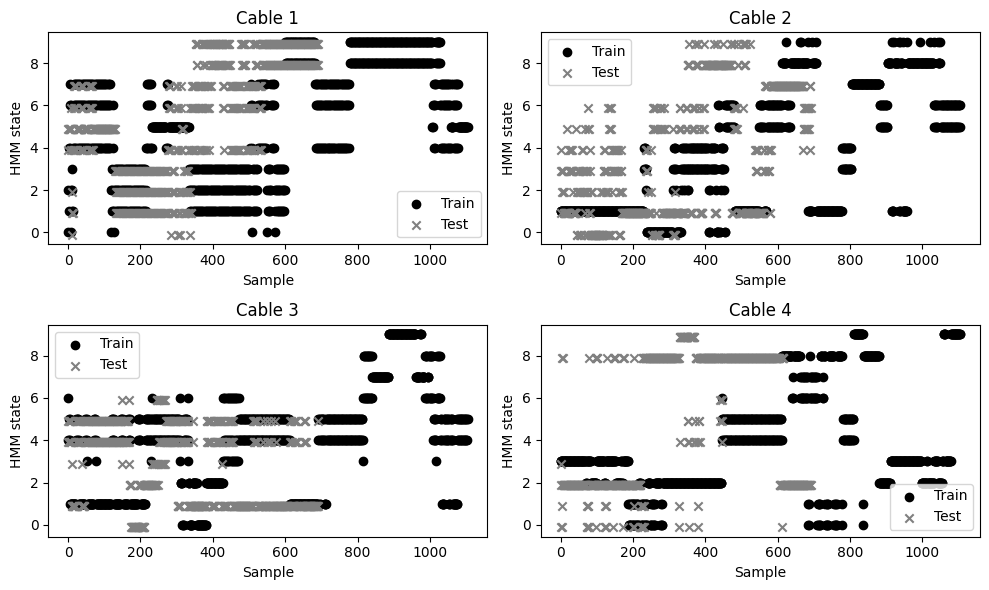

In [91]:
n_clusters = 20
n_components = 10

pipelines = {
    f"c{k}": Pipeline([
        ("feature_selector", ColumnTransformer([("selector", "passthrough", selected_bands[f"c{k}"])], remainder="drop")),
        ("scaler", StandardScaler()),
        ("quantizer", KMeansQuantizer(n_clusters=n_clusters)),
        #("pca", PCA(n_components=2)),
        ("hmm", make_categorical_hmm(n_components=n_components, n_features=n_clusters, initialize=None))
    ]) for k in range(4)
}

for cable in range(4):
    pipelines[f"c{cable}"].fit(gb_dataset_2[f"c{cable}"])

# results

traj_train = {}
traj_test = {}
for cable in range(4):
    traj_train[f"c{cable}"] = pipelines[f"c{cable}"].predict(gb_dataset_2[f"c{cable}"])
    traj_test[f"c{cable}"] = pipelines[f"c{cable}"].predict(gb_dataset_1[f"c{cable}"])
    # mapping
    mapping = get_state_order(traj_train[f"c{cable}"])
    traj_train[f"c{cable}"] = np.array([mapping[i] for i in traj_train[f"c{cable}"]])
    traj_test[f"c{cable}"] = np.array([mapping[i] for i in traj_test[f"c{cable}"]])

# plot 

plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.scatter(gb_dataset_2[f"c{cable}"].tension, traj_train[f"c{cable}"], marker='o', color="k")
    plt.scatter(gb_dataset_1[f"c{cable}"].tension, traj_test[f"c{cable}"]-0.1, marker='x', color="grey")
    plt.xlabel("Tension (N)")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    samples_train = np.arange(len(traj_train[f"c{cable}"]))
    samples_test = np.arange(len(traj_test[f"c{cable}"]))
    plt.scatter(samples_train, traj_train[f"c{cable}"], marker='o', color="k")
    plt.scatter(samples_test, traj_test[f"c{cable}"]-0.1, marker='x', color="grey")
    plt.xlabel("Sample")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

Left-right

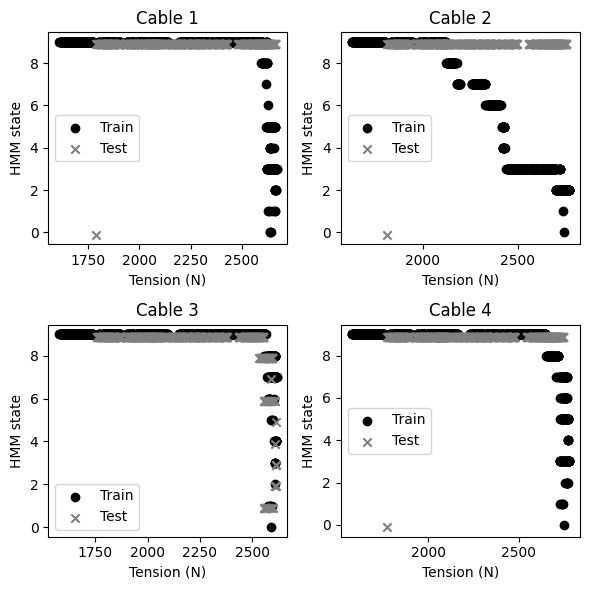

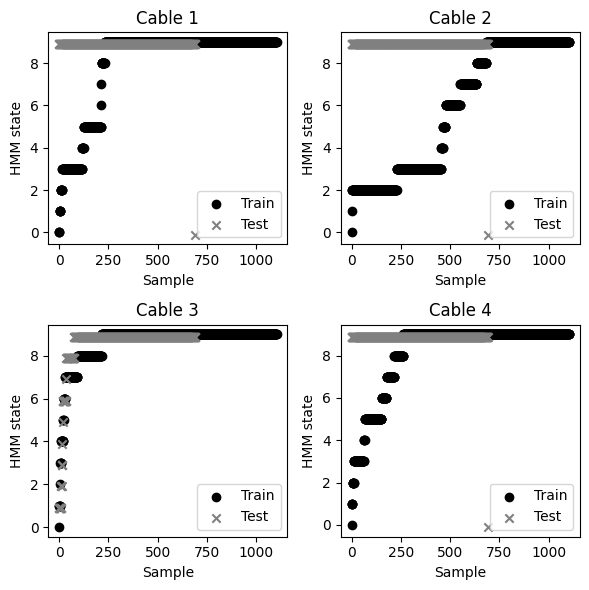

In [167]:
n_clusters = 20
n_components = 10

pipelines = {
    f"c{k}": Pipeline([
        ("feature_selector", ColumnTransformer([("selector", "passthrough", selected_bands[f"c{k}"])], remainder="drop")),
        ("scaler", StandardScaler()),
        ("quantizer", KMeansQuantizer(n_clusters=n_clusters)),
        #("pca", PCA(n_components=2)),
        ("hmm", make_categorical_hmm(n_components=n_components, n_features=n_clusters, initialize=initialize_left_right))
    ]) for k in range(4)
}

for cable in range(4):
    pipelines[f"c{cable}"].fit(gb_dataset_2[f"c{cable}"])

# results

traj_train = {}
traj_test = {}
for cable in range(4):
    traj_train[f"c{cable}"] = pipelines[f"c{cable}"].predict(gb_dataset_2[f"c{cable}"])
    traj_test[f"c{cable}"] = pipelines[f"c{cable}"].predict(gb_dataset_1[f"c{cable}"])
    # mapping
    mapping = get_state_order(traj_train[f"c{cable}"])
    traj_train[f"c{cable}"] = np.array([mapping[i] for i in traj_train[f"c{cable}"]])
    traj_test[f"c{cable}"] = np.array([mapping[i] for i in traj_test[f"c{cable}"]])

# plot 

plt.figure(figsize=(6,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.scatter(gb_dataset_2[f"c{cable}"].tension, traj_train[f"c{cable}"], marker='o', color="k")
    plt.scatter(gb_dataset_1[f"c{cable}"].tension, traj_test[f"c{cable}"]-0.1, marker='x', color="grey")
    plt.xlabel("Tension (N)")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

plt.figure(figsize=(6,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    samples_train = np.arange(len(traj_train[f"c{cable}"]))
    samples_test = np.arange(len(traj_test[f"c{cable}"]))
    plt.scatter(samples_train, traj_train[f"c{cable}"], marker='o', color="k")
    plt.scatter(samples_test, traj_test[f"c{cable}"]-0.1, marker='x', color="grey")
    plt.xlabel("Sample")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

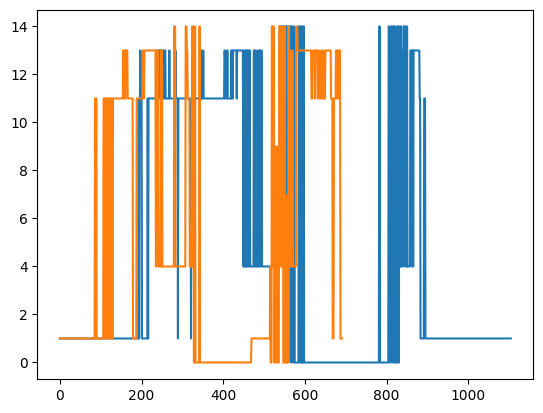

In [139]:
x_train = pipelines["c0"][0:3].transform(gb_dataset_2[f"c{cable}"])
x_test = pipelines["c0"][0:3].transform(gb_dataset_1[f"c{cable}"])

plt.plot(x_train)
plt.plot(x_test)

In [140]:
from lib.hmm_utils import initialize_left_right_extra

In [142]:
labels = traj_train[f"c{cable}"]

time = np.arange(len(labels))
traj = pd.DataFrame({"time": time, "label": labels})
grouped = traj.groupby("label").mean()
original_labels = grouped.index.to_numpy()
idx = original_labels[grouped.time.to_numpy().argsort()]
mapping = {k: v for k,v in zip(idx, original_labels)} # old_state: new_state


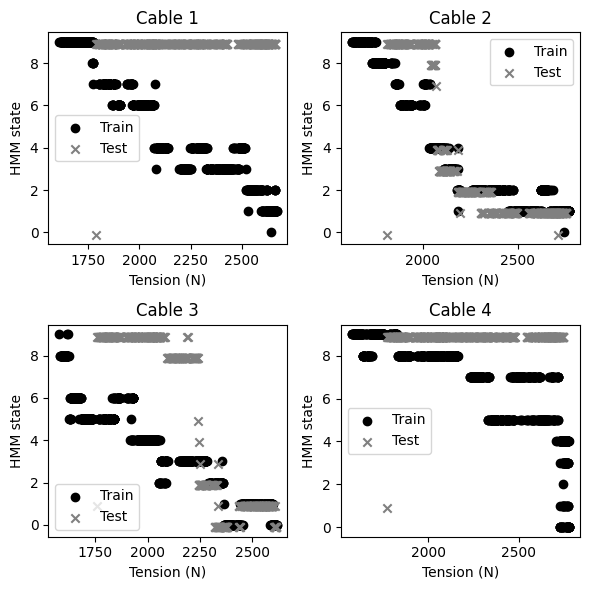

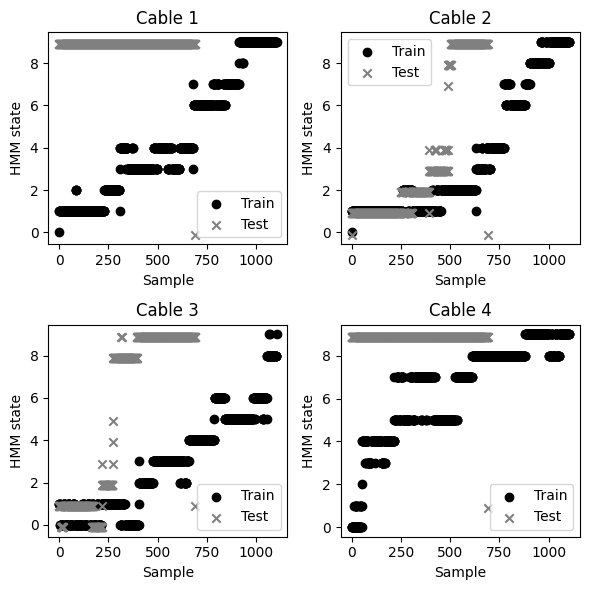

In [168]:
n_clusters = 10
n_components = 10

pipelines = {
    f"c{k}": Pipeline([
        ("feature_selector", ColumnTransformer([("selector", "passthrough", selected_bands[f"c{k}"])], remainder="drop")),
        ("scaler", StandardScaler()),
        ("quantizer", KMeansQuantizer(n_clusters=n_clusters)),
        #("pca", PCA(n_components=2)),
        ("hmm", make_categorical_hmm(n_components=n_components, n_features=n_clusters, initialize=initialize_left_right_extra))
    ]) for k in range(4)
}

for cable in range(4):
    pipelines[f"c{cable}"].fit(gb_dataset_2[f"c{cable}"])

# results

traj_train = {}
traj_test = {}
for cable in range(4):
    traj_train[f"c{cable}"] = pipelines[f"c{cable}"].predict(gb_dataset_2[f"c{cable}"])
    traj_test[f"c{cable}"] = pipelines[f"c{cable}"].predict(gb_dataset_1[f"c{cable}"])
    # mapping
    mapping = get_state_order(traj_train[f"c{cable}"])
    traj_train[f"c{cable}"] = np.array([mapping[i] for i in traj_train[f"c{cable}"]])
    traj_test[f"c{cable}"] = np.array([mapping[i] for i in traj_test[f"c{cable}"]])

# plot 

plt.figure(figsize=(6,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.scatter(gb_dataset_2[f"c{cable}"].tension, traj_train[f"c{cable}"], marker='o', color="k")
    plt.scatter(gb_dataset_1[f"c{cable}"].tension, traj_test[f"c{cable}"]-0.1, marker='x', color="grey")
    plt.xlabel("Tension (N)")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

plt.figure(figsize=(6,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    samples_train = np.arange(len(traj_train[f"c{cable}"]))
    samples_test = np.arange(len(traj_test[f"c{cable}"]))
    plt.scatter(samples_train, traj_train[f"c{cable}"], marker='o', color="k")
    plt.scatter(samples_test, traj_test[f"c{cable}"]-0.1, marker='x', color="grey")
    plt.xlabel("Sample")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

In [ ]:
# # visualization

# plt.figure(figsize=(20,4))
# for cable in range(4):
#     plt.subplot(1,4,cable+1)
#     plt.title(f"Cable {cable+1}")
#     t = np.array(tensions_dataset_2[f"{cable}"])
#     x_axis = np.arange(x_train[f"c{cable}"].shape[1])
#     plt.plot(t, x_train[f"c{cable}"])
#     plt.xlabel("Tension (N)")
#     plt.ylabel("Energy/bandwidth")
# plt.suptitle("Training dataset");

# plt.figure(figsize=(20,4))
# for cable in range(4):
#     plt.subplot(1,4,cable+1)
#     plt.title(f"Cable {cable+1}")
#     t = np.array(tensions_dataset_1[f"{cable}"])
#     x_axis = np.arange(x_test[f"c{cable}"].shape[1])
#     plt.plot(t, x_test[f"c{cable}"])
#     plt.xlabel("Tension (N)")
#     plt.ylabel("Energy/bandwidth")
# plt.suptitle("Test dataset");

In [ ]:
# n_components = 10
# n_mix = 1

# hmm_per_cable = {}
# for cable in range(4):
#     hmm_per_cable[f"c{cable}"] = train_hmm(
#         x=x_train[f"c{cable}"],
#         n_components=n_components,
#         n_mix=n_mix,
#         initialize=None,
#         covariance_type="diag",
#         tol=1e-7
#     )


In [ ]:
# traj_train = {}
# traj_test = {}
# for cable in range(4):
#     traj_train[f"c{cable}"] = hmm_per_cable[f"c{cable}"].predict(x_train[f"c{cable}"])
#     traj_test[f"c{cable}"] = hmm_per_cable[f"c{cable}"].predict(x_test[f"c{cable}"])

In [ ]:
# cable = 3

# traj = traj_train[f"c{cable}"]
# means = hmm_per_cable[f"c{cable}"].means_.squeeze()
# stds = np.sqrt(hmm_per_cable[f"c{cable}"].covars_.squeeze())

# traj.shape, means.shape

# plt.figure(figsize=(6,3))
# for feat in range(1):
#     plt.subplot(1,1,feat+1)
#     t = np.array(tensions_dataset_2[f"{cable}"])
#     t = np.arange(len(t))
#     x_axis = np.arange(x_train[f"c{cable}"].shape[1])
#     plt.plot(t, x_train[f"c{cable}"][:,feat], color="k", alpha=0.5)
#     # plt.plot(t, means[traj][:,feat], color="blue")
#     plt.plot(t, means[traj], color="blue")
#     #plt.fill_between(t, means[traj][:,feat] - 2*stds[traj][:,feat], means[traj][:,feat] + 2*stds[traj][:,feat], color="blue", alpha=0.35)
#     plt.fill_between(t, means[traj] - 2*stds[traj], means[traj] + 2*stds[traj], color="blue", alpha=0.35)
#     plt.xlabel("Samples")
#     plt.ylabel("Energy/bandwidth")
#     plt.suptitle(f"Training dataset, cable {cable+1}");
# plt.tight_layout()


In [ ]:
# plt.figure(figsize=(10,6))

# for cable in range(4):
#     plt.subplot(2,2,cable+1)
#     plt.title(f"Cable {cable+1}")
#     plt.scatter(tensions_dataset_2[f"{cable}"], traj_train[f"c{cable}"], marker='o')
#     plt.scatter(tensions_dataset_1[f"{cable}"], traj_test[f"c{cable}"]-0.1, marker='x')
#     plt.xlabel("Tension (N)")
#     plt.ylabel("HMM state")
#     plt.legend(["Train", "Test"])
# plt.tight_layout()

In [ ]:
# possible_train_states = np.unique(traj_train[f"c{cable}"])

In [ ]:
# plt.figure(figsize=(12,7))
# for cable in range(4):
#     tensions = np.array(tensions_dataset_2[f"{cable}"])
#     state_traj = traj_train[f"c{cable}"]
#     t_min = tensions.min()
#     t_max = tensions.max()
#     num_states = len(possible_train_states)

#     for i, state in enumerate(possible_train_states):
#         plt.subplot(4, num_states, cable*num_states + i+1)
#         plt.title(f"State {state}", fontsize=10)
#         bins = np.arange(t_min, t_max, 15)
#         plt.hist(tensions[state_traj == state], bins=bins, orientation="horizontal", edgecolor="k");
#         plt.ylim([t_min, t_max])
#         plt.xlim([0,400])
#         plt.ylabel("Tensions (N)", fontsize=10)
#     plt.tight_layout()

In [ ]:
# plt.figure(figsize=(20,4))

# for cable in range(4):
#     plt.subplot(1,4,cable+1)
#     plt.title(f"Cable {cable+1}")
#     traj = traj_train[f"c{cable}"]
#     plt.scatter(np.arange(len(traj)), traj)
#     plt.xlabel("Sample number")
#     plt.ylabel("State")

In [ ]:
# def plot_graph(ax, adjacency_matrix):
#     G = nx.from_numpy_array(adjacency_matrix)
#     edges = G.edges()
#     weights = np.array([G[u][v]['weight'] for u,v in edges])
#     weights_mod = weights
#     weights_mod[weights>=0.9] = 1.5
#     weights_mod[(weights>0.1) & (weights<0.9)] = 0.75
#     weights_mod[(weights>0.01) & (weights<0.1)] = 0.5
#     weights_mod[(weights<0.01) & ((weights>0))] = 0.1
#     weights_mod[weights==0] = 0
#     nx.draw(G, ax=ax, node_size=500, with_labels=True, width=weights_mod, node_color="grey", edgecolors="k", pos=nx.circular_layout(G))

In [ ]:
# fig = plt.figure(figsize=(20,4))
# for cable in range(4):
#     ax = fig.add_subplot(1,4,cable+1)
#     plt.title(f"Cable: {cable+1}")
#     plot_graph(ax=ax, adjacency_matrix=hmm_per_cable[f"c{cable}"].transmat_)

### Left-right

In [ ]:
# n_components = 4
# n_mix = 1

# hmm_per_cable = {}
# for cable in range(4):
#     print(cable)
#     hmm_per_cable[f"c{cable}"] = train_hmm(
#         x=x_train[f"c{cable}"],
#         n_components=n_components,
#         n_mix=n_mix,
#         initialize=initialize_left_right,
#         covariance_type="full"
#     )


In [ ]:
# traj_train = {}
# traj_test = {}
# for cable in range(4):
#     print(cable)
#     traj_train[f"c{cable}"] = hmm_per_cable[f"c{cable}"].predict(x_train[f"c{cable}"])
#     traj_test[f"c{cable}"] = hmm_per_cable[f"c{cable}"].predict(x_test[f"c{cable}"])

In [ ]:
# plt.figure(figsize=(10,6))

# for cable in range(4):
#     plt.subplot(2,2,cable+1)
#     plt.title(f"Cable {cable+1}")
#     plt.scatter(tensions_dataset_2[f"{cable}"], traj_train[f"c{cable}"], marker='o')
#     plt.scatter(tensions_dataset_1[f"{cable}"], traj_test[f"c{cable}"]-0.1, marker='x')
#     plt.xlabel("Tension (N)")
#     plt.ylabel("HMM state")
#     plt.legend(["Train", "Test"])
# plt.tight_layout()

In [ ]:
# possible_train_states = np.unique(traj_train[f"c{cable}"])

In [ ]:
# plt.figure(figsize=(20,4))

# for cable in range(4):
#     plt.subplot(1,4,cable+1)
#     plt.title(f"Cable {cable+1}")
#     traj = traj_train[f"c{cable}"]
#     plt.scatter(np.arange(len(traj)), traj)
#     plt.xlabel("Sample number")
#     plt.ylabel("State")

In [ ]:
# fig = plt.figure(figsize=(20,4))
# for cable in range(4):
#     ax = fig.add_subplot(1,4,cable+1)
#     plt.title(f"Cable: {cable+1}")
#     plot_graph(ax=ax, adjacency_matrix=hmm_per_cable[f"c{cable}"].transmat_)

### Left-right with 1 neighbor

In [ ]:
# plt.imshow(initialize_neighbor(5), cmap="binary")
# plt.grid(False)

In [ ]:
# n_components = 4
# n_mix = 2

# hmm_per_cable = {}
# for cable in range(4):
#     print(cable)
#     hmm_per_cable[f"c{cable}"] = train_hmm(
#         x=x_train[f"c{cable}"],
#         n_components=n_components,
#         n_mix=n_mix,
#         initialize=initialize_neighbor,
#         covariance_type="full"
#     )


In [ ]:
# traj_train = {}
# traj_test = {}
# for cable in range(4):
#     print(cable)
#     traj_train[f"c{cable}"] = hmm_per_cable[f"c{cable}"].predict(x_train[f"c{cable}"])
#     traj_test[f"c{cable}"] = hmm_per_cable[f"c{cable}"].predict(x_test[f"c{cable}"])

In [ ]:
# plt.figure(figsize=(10,6))

# for cable in range(4):
#     plt.subplot(2,2,cable+1)
#     plt.title(f"Cable {cable+1}")
#     plt.scatter(tensions_dataset_2[f"{cable}"], traj_train[f"c{cable}"], marker='o')
#     plt.scatter(tensions_dataset_1[f"{cable}"], traj_test[f"c{cable}"]-0.1, marker='x')
#     plt.xlabel("Tension (N)")
#     plt.ylabel("HMM state")
#     plt.legend(["Train", "Test"])
# plt.tight_layout()

In [ ]:
# possible_train_states = np.unique(traj_train[f"c{cable}"])

In [ ]:
# plt.figure(figsize=(20,4))

# for cable in range(4):
#     plt.subplot(1,4,cable+1)
#     plt.title(f"Cable {cable+1}")
#     traj = traj_train[f"c{cable}"]
#     plt.scatter(np.arange(len(traj)), traj)
#     plt.xlabel("Sample number")
#     plt.ylabel("State")

In [ ]:
# fig = plt.figure(figsize=(20,4))
# for cable in range(4):
#     ax = fig.add_subplot(1,4,cable+1)
#     plt.title(f"Cable: {cable+1}")
#     plot_graph(ax=ax, adjacency_matrix=hmm_per_cable[f"c{cable}"].transmat_)

### Two-state left-right

In [ ]:
# def initialize_left_right_2(full_components):
#     n_components = full_components//2
#     A = np.zeros((full_components, full_components))
#     # A[0,0] = 0.5
#     # A[0,1] = 0.25
#     A[n_components-1,n_components-1] = 0.5
#     A[n_components-1,2*n_components-1] = 0.5
#     A[2*n_components - 1, 2*n_components - 1] = 0.5
#     A[2*n_components - 1, n_components - 1] = 0.5
#     for i in range(0, n_components-1):
#         A[i,i] = 0.5
#         A[i,i+1] = 0.25
#         A[i,i+n_components] = 0.25
#         A[i+n_components,i] = 0.5
#         A[i+n_components,i+n_components] = 0.5

#     return A

In [ ]:
# n_components = 6
# n_mix = 1

# hmm_per_cable = {}
# for cable in range(4):
#     hmm_per_cable[f"c{cable}"] = train_hmm(
#         x=x_train[f"c{cable}"], n_components=n_components, n_mix=n_mix, initialize=initialize_left_right_2, covariance_type="diag"
#     )


In [ ]:
# traj_train = {f"c{cable}": hmm_per_cable[f"c{cable}"].predict(x_train[f"c{cable}"]) for cable in range(4)}
# traj_test = {f"c{cable}": hmm_per_cable[f"c{cable}"].predict(x_test[f"c{cable}"]) for cable in range(4)}

In [ ]:
# plt.figure(figsize=(10,6))

# for cable in range(4):
#     plt.subplot(2,2,cable+1)
#     plt.title(f"Cable {cable+1}")
#     plt.scatter(tensions_dataset_2[f"{cable}"], traj_train[f"c{cable}"], marker='o')
#     plt.scatter(tensions_dataset_1[f"{cable}"], traj_test[f"c{cable}"]-0.1, marker='x')
#     plt.xlabel("Tension (N)")
#     plt.ylabel("HMM state")
#     plt.legend(["Train", "Test"])
# plt.tight_layout()